# Applied Data Analysis – Assignment 1

**Dataset:** The Movies Dataset (movies_metadata + credits + ratings)  
**Goal:** EDA, cleaning, visualization, and feature engineering on movie-level data.

I use multiple CSV files from *The Movies Dataset* (movies_metadata, credits, ratings, etc.) and build a unified movie-level DataFrame `df` that combines:
- Movie metadata  
- Director / cast / crew features  
- Aggregated ratings  

Then I perform:
1. Exploratory Analysis & Data Cleaning  
2. Data Visualization  
3. Feature Engineering (MI + PCA + reflection)


In [143]:
import sys
!{sys.executable} -m pip install pandas plotly matplotlib seaborn wordcloud scikit-learn requests beautifulsoup4 pandas openpyxl pio




In [144]:
# 0. Imports & settings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter
from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA

import plotly.express as px

import plotly.io as pio


sns.set(style="whitegrid")
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)


## 1. Data Loading & Initial Exploration

In this section, I load the CSV files from *The Movies Dataset* and quickly inspect:

- Available tables and their columns  
- Basic info and missing values  
- A first idea of which tables are useful for movie-level analysis


In [145]:
# 1.1 Load all relevant CSVs

credits         = pd.read_csv("./credits.csv")
keywords        = pd.read_csv("./keywords.csv")
links           = pd.read_csv("./links.csv")
links_small     = pd.read_csv("./links_small.csv")
movies_metadata = pd.read_csv("./movies_metadata.csv")
ratings         = pd.read_csv("./ratings.csv")
ratings_small   = pd.read_csv("./ratings_small.csv")

print("credits columns:", credits.columns.tolist())
print("keywords columns:", keywords.columns.tolist())
print("links columns:", links.columns.tolist())
print("links_small columns:", links_small.columns.tolist())
print("movies_metadata columns:", movies_metadata.columns.tolist())
print("ratings columns:", ratings.columns.tolist())
print("ratings_small columns:", ratings_small.columns.tolist())


/var/folders/rd/md41z1_d7z118d5qr2k0hjtm0000gn/T/ipykernel_2625/3267898770.py:7: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.



credits columns: ['cast', 'crew', 'id']
keywords columns: ['id', 'keywords']
links columns: ['movieId', 'imdbId', 'tmdbId']
links_small columns: ['movieId', 'imdbId', 'tmdbId']
movies_metadata columns: ['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count']
ratings columns: ['userId', 'movieId', 'rating', 'timestamp']
ratings_small columns: ['userId', 'movieId', 'rating', 'timestamp']


In [146]:
# 1.2 Missing values in the main tables

print("movies_metadata missing:")
print(movies_metadata.isnull().sum().sort_values(ascending=False).head(20), "\n")


movies_metadata missing:
belongs_to_collection    40972
homepage                 37684
tagline                  25054
overview                   954
poster_path                386
runtime                    263
status                      87
release_date                87
imdb_id                     17
original_language           11
spoken_languages             6
title                        6
video                        6
vote_average                 6
revenue                      6
vote_count                   6
popularity                   5
production_companies         3
production_countries         3
original_title               0
dtype: int64 



In [147]:
movies_metadata["belongs_to_collection"].fillna("None", inplace=True)
movies_metadata["homepage"].fillna("None", inplace=True)
movies_metadata["tagline"].fillna("None", inplace=True) 
movies_metadata["overview"].fillna("None", inplace=True)
movies_metadata["poster_path"].fillna("None", inplace=True)
movies_metadata["runtime"].fillna(movies_metadata["runtime"].mean())
movies_metadata["status"].fillna("Unkown", inplace=True)
movies_metadata = movies_metadata[movies_metadata['imdb_id'].notna()]
movies_metadata["original_language"].fillna("None", inplace=True)
movies_metadata.reset_index()

/var/folders/rd/md41z1_d7z118d5qr2k0hjtm0000gn/T/ipykernel_2625/1539795762.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/rd/md41z1_d7z118d5qr2k0hjtm0000gn/T/ipykernel_2625/1539795762.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df

index  adult                              belongs_to_collection    budget                                             genres  \
0          0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1          1  False                                               None  65000000  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2          2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3          3  False                                               None  16000000  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4          4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0                     [{'id': 35, 'name': 'Comedy'}]   
...      ...    ...                                                ...       ...                                                ...   
45444  45461  False                                               None         0  [{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...   
45445  45462  False                                               None         0                      [{'id': 18, 'name': 'Drama'}]   
45446  45463  False                                               None         0  [{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...   
45447  45464  False                                               None         0                                                 []   
45448  45465  False                                               None         0                                                 []   

                                   homepage      id    imdb_id original_language               original_title  \
0      http://toystory.disney.com/toy-story     862  tt0114709                en                    Toy Story   
1                                      None    8844  tt0113497                en                      Jumanji   
2                                      None   15602  tt0113228                en             Grumpier Old Men   
3                                      None   31357  tt0114885                en            Waiting to Exhale   
4                                      None   11862  tt0113041                en  Father of the Bride Part II   
...                                     ...     ...        ...               ...                          ...   
45444  http://www.imdb.com/title/tt6209470/  439050  tt6209470                fa                      رگ خواب   
45445                                  None  111109  tt2028550                tl          Siglo ng Pagluluwal   
45446                                  None   67758  tt0303758                en                     Betrayal   
45447                                  None  227506  tt0008536                en          Satana likuyushchiy   
45448                                  None  461257  tt6980792                en                     Queerama   

                                                overview popularity                       poster_path  \
0      Led by Woody, Andy's toys live happily in his ...  21.946943  /rhIRbceoE9lR4veEXuwCC2wARtG.jpg   
1      When siblings Judy and Peter discover an encha...  17.015539  /vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg   
2      A family wedding reignites the ancient feud be...    11.7129  /6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg   
3      Cheated on, mistreated and stepped on, the wom...   3.859495  /16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg   
4      Just when George Banks has recovered from his ...   8.387519  /e64sOI48hQXyru7naBFyssKFxVd.jpg   
...                                                  ...        ...                               ...   
45444        Rising and falling between a man and woman.   0.072051  /jldsYflnId4tTWPx8es3uzsB1I8.jpg   
45445  An artist struggles to finish his work while a...   0.178241  /xZkmxsNmYXJbKVsTRLLx3pqGHx7.jpg   
45446  When one of her hits goes wrong, a professiona...   0.903007  /d5bX92nDsISNhu

In [148]:
print("keywords missing:")
print(keywords.isnull().sum(), "\n")

print("links missing:")
print(links.isnull().sum(), "\n")

print("links_small missing:")
print(links_small.isnull().sum(), "\n")


keywords missing:
id          0
keywords    0
dtype: int64 

links missing:
movieId      0
imdbId       0
tmdbId     219
dtype: int64 

links_small missing:
movieId     0
imdbId      0
tmdbId     13
dtype: int64 



In [149]:
links = links[links['tmdbId'].notna()]
links.reset_index()

links_small = links_small[links_small['tmdbId'].notna()]
links_small.reset_index()


index  movieId   imdbId    tmdbId
0         0        1   114709     862.0
1         1        2   113497    8844.0
2         2        3   113228   15602.0
3         3        4   114885   31357.0
4         4        5   113041   11862.0
...     ...      ...      ...       ...
9107   9120   162672  3859980  402672.0
9108   9121   163056  4262980  315011.0
9109   9122   163949  2531318  391698.0
9110   9123   164977    27660  137608.0
9111   9124   164979  3447228  410803.0

[9112 rows x 4 columns]

In [150]:
print("ratings missing:")
print(ratings.isnull().sum(), "\n")

print("ratings_small missing:")
print(ratings_small.isnull().sum(), "\n")

ratings missing:


userId       0
movieId      0
rating       0
timestamp    0
dtype: int64 

ratings_small missing:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64 



In [151]:
# 1.3 Basic info for key tables

print("=== credits.info() ===")
credits.info()
print("\n=== keywords.info() ===")
keywords.info()
print("\n=== movies_metadata.info() ===")
movies_metadata.info()


=== credits.info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB

=== keywords.info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB

=== movies_metadata.info() ===
<class 'pandas.core.frame.DataFrame'>
Index: 45449 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45449 non-null  object 
 1   belon

### Basic Feature Extraction on movies_metadata

Here I create some helpful basic features from movies_metadata:

- `release_year`, `release_month` from `release_date`  
- `title_length` (number of characters in the title)  
- `overview_length` (number of words in the overview)  
- Convert `popularity` to numeric and bin it into three categories: Low / Medium / High  
- Parse `genres`, `production_companies`, `production_countries`


In [152]:
# Parse release date and extract year and month
movies_metadata["release_date"] = pd.to_datetime(
    movies_metadata["release_date"], errors="coerce"
)
movies_metadata["release_year"] = movies_metadata["release_date"].dt.year
movies_metadata["release_month"] = movies_metadata["release_date"].dt.month

# Title and overview lengths
movies_metadata["title_length"] = movies_metadata["title"].apply(
    lambda x: len(str(x))
)
movies_metadata["overview_length"] = movies_metadata["overview"].apply(
    lambda x: len(str(x).split())
)

# popularity as numeric
movies_metadata["popularity"] = pd.to_numeric(
    movies_metadata["popularity"], errors="coerce"
)
movies_metadata = movies_metadata.dropna(subset=["popularity"])

# Popularity category (Low / Medium / High)
movies_metadata["popularity_category"] = pd.qcut(
    movies_metadata["popularity"], 3, labels=["Low", "Medium", "High"]
)

movies_metadata[["popularity", "popularity_category"]].head()


popularity popularity_category
0   21.946943                High
1   17.015539                High
2   11.712900                High
3    3.859495                High
4    8.387519                High

In [153]:
# Parse genres: JSON-like string → list of names

movies_metadata["genres"] = movies_metadata["genres"].fillna("[]").apply(ast.literal_eval)
movies_metadata["genres_list"] = movies_metadata["genres"].apply(
    lambda x: [i["name"] for i in x] if x else []
)
movies_metadata["main_genre"] = movies_metadata["genres_list"].apply(
    lambda x: x[0] if len(x) > 0 else "Unknown"
)

# Parse production_companies and production_countries to list of names
movies_metadata["production_companies"] = movies_metadata["production_companies"].fillna("[]").apply(ast.literal_eval)
movies_metadata["production_companies"] = movies_metadata["production_companies"].apply(
    lambda x: [i["name"] for i in x] if x else []
)

movies_metadata["production_countries"] = movies_metadata["production_countries"].fillna("[]").apply(ast.literal_eval)
movies_metadata["production_countries"] = movies_metadata["production_countries"].apply(
    lambda x: [i["name"] for i in x] if x else []
)

movies_metadata[["title", "release_year", "main_genre", "title_length", "overview_length"]].head()


title  release_year main_genre  title_length  overview_length
0                    Toy Story        1995.0  Animation             9               50
1                      Jumanji        1995.0  Adventure             7               67
2             Grumpier Old Men        1995.0    Romance            16               56
3            Waiting to Exhale        1995.0     Comedy            17               45
4  Father of the Bride Part II        1995.0     Comedy            27               59

### Parsing credits (cast & crew)

From credits, I extract:

- `director` (from crew list)  
- `num_cast` (number of cast members)  
- `num_crew` (number of crew members)


In [154]:
# Parse cast and crew JSON strings
credits["cast"] = credits["cast"].fillna("[]").apply(ast.literal_eval)
credits["crew"] = credits["crew"].fillna("[]").apply(ast.literal_eval)

def get_director(crew_list):
    for member in crew_list:
        if member.get("job") == "Director":
            return member.get("name")
    return np.nan

credits["director"] = credits["crew"].apply(get_director)
credits["num_cast"] = credits["cast"].apply(lambda x: len(x))
credits["num_crew"] = credits["crew"].apply(lambda x: len(x))

credits[["id", "director", "num_cast", "num_crew"]].head()


id         director  num_cast  num_crew
0    862    John Lasseter        13       106
1   8844     Joe Johnston        26        16
2  15602    Howard Deutch         7         4
3  31357  Forest Whitaker        10        10
4  11862    Charles Shyer        12         7

## 2. Data Cleaning, Merging, and Preprocessing

Now I:

- Clean `id` fields and align them across tables  
- Merge movies_metadata with director/cast features from credits  
- Aggregate ratings (mean, count, variance) per movie  
- Create additional numeric features: `profit`, `ROI`, `weighted_rating`, `director_experience`  
- Build a unified movie-level DataFrame `df`


In [155]:
# Convert IDs to numeric
movies_metadata["id"] = pd.to_numeric(movies_metadata["id"], errors="coerce")
links["tmdbId"] = pd.to_numeric(links["tmdbId"], errors="coerce")

# Remove invalid IDs
movies_metadata = movies_metadata.dropna(subset=["id"])
links = links.dropna(subset=["tmdbId"])

movies_metadata["id"] = movies_metadata["id"].astype(int)
links["tmdbId"] = links["tmdbId"].astype(int)

print("After cleaning invalid IDs:")
print("movies_metadata rows:", len(movies_metadata))
print("links rows:", len(links))


After cleaning invalid IDs:
movies_metadata rows: 45443
links rows: 45624


In [156]:
print(f"movies_metadata 'id' duplicates: {movies_metadata.duplicated(subset=['id']).sum()}")

print(f"links 'movieId' duplicates: {links.duplicated(subset=['movieId']).sum()}")
print(f"links 'tmdbId' duplicates: {links.duplicated(subset=['tmdbId']).sum()}")
print(f"links_small 'movieId' duplicates: {links_small.duplicated(subset=['movieId']).sum()}")
print(f"links_small 'tmdbId' duplicates: {links_small.duplicated(subset=['tmdbId']).sum()}")

print(f"ratings duplicates: {ratings.duplicated(subset=['userId', 'movieId']).sum()}")
print(f"ratings_small duplicates: {ratings_small.duplicated(subset=['userId', 'movieId']).sum()}")

print(f"credits duplicates: {credits.duplicated(subset=['id']).sum()}")
print(f"keywords duplicates: {keywords.duplicated(subset=['id']).sum()}")

movies_metadata 'id' duplicates: 30
links 'movieId' duplicates: 0
links 'tmdbId' duplicates: 30
links_small 'movieId' duplicates: 0
links_small 'tmdbId' duplicates: 0
ratings duplicates: 0
ratings_small duplicates: 0
credits duplicates: 44
keywords duplicates: 987


In [157]:
movies_metadata = movies_metadata.drop_duplicates(subset="id").reset_index(drop=True)

print("Number of duplicated movie IDs after cleaning:",
      movies_metadata["id"].duplicated().sum())

Number of duplicated movie IDs after cleaning: 0


In [158]:
links = links.drop_duplicates(subset="tmdbId").reset_index(drop=True)

print("Number of duplicated tmdbId after cleaning:",
      links["tmdbId"].duplicated().sum())

Number of duplicated tmdbId after cleaning: 0


In [159]:
credits = credits.drop_duplicates(subset="id").reset_index(drop=True)

print("Number of duplicated credits IDs after cleaning:",
      credits["id"].duplicated().sum())

Number of duplicated credits IDs after cleaning: 0


In [160]:
# 2.2 Merge metadata with director / cast features

df = movies_metadata.merge(
    credits[["id", "director", "num_cast", "num_crew"]],
    on="id",
    how="left",
)
df.head()


adult                              belongs_to_collection    budget                                             genres  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  False                                               None  65000000  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  False                                               None  16000000  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language               original_title  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en                    Toy Story   
1                                  None   8844  tt0113497                en                      Jumanji   
2                                  None  15602  tt0113228                en             Grumpier Old Men   
3                                  None  31357  tt0114885                en            Waiting to Exhale   
4                                  None  11862  tt0113041                en  Father of the Bride Part II   

                                            overview  popularity                       poster_path  \
0  Led by Woody, Andy's toys live happily in his ...   21.946943  /rhIRbceoE9lR4veEXuwCC2wARtG.jpg   
1  When siblings Judy and Peter discover an encha...   17.015539  /vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg   
2  A family wedding reignites the ancient feud be...   11.712900  /6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg   
3  Cheated on, mistreated and stepped on, the wom...    3.859495  /16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg   
4  Just when George Banks has recovered from his ...    8.387519  /e64sOI48hQXyru7naBFyssKFxVd.jpg   

                                production_companies        production_countries release_date      revenue  runtime  \
0                          [Pixar Animation Studios]  [United States of America]   1995-10-30  373554033.0     81.0   
1  [TriStar Pictures, Teitler Film, Interscope Co...  [United States of America]   1995-12-15  262797249.0    104.0   
2                     [Warner Bros., Lancaster Gate]  [United States of America]   1995-12-22          0.0    101.0   
3           [Twentieth Century Fox Film Corporation]  [United States of America]   1995-12-22   81452156.0    127.0   
4       [Sandollar Productions, Touchstone Pictures]  [United States of America]   1995-02-10   76578911.0    106.0   

                                    spoken_languages    status                                            tagline  \
0           [{'iso_639_1': 'en', 'name': 'English'}]  Released                                               None   
1  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released          Roll the dice and unleash the excitement!   
2           [{'iso_639_1': 'en', 'name': 'English'}]  Released  Still Yelling. Still Fighting. Still Ready for...   
3           [{'iso_639_1': 'en', 'name': 'English'}]  Released  Friends are the people who let you be yourself...   
4           [{'iso_639_1': 'en', 'name': 'English'}]  Released  Just When His World Is Back To Normal... He's ...   

                         title  video  vote_average  vote_count  release_year  release_month  title_length  overview_length  \
0                    Toy Story  False           7.7      5415.0        1995.0           10.0             9               50   
1                      Jumanji  False           6.9      2413.0        1995.0           12.0             7               67   
2             Grumpier Old Men  False           6.5        92.0        1995.0           12.0            16               56   
3            Waiting to Exhale  False           6.1        34.0       

In [161]:
# 2.3 Aggregate ratings (mean, count, variance) per movie (using full ratings.csv)

ratings_summary = (
    ratings.groupby("movieId")["rating"]
    .agg(["mean", "count", "var"])
    .reset_index()
)
ratings_summary.columns = ["movieId", "avg_rating", "num_ratings", "rating_variance"]

df = df.merge(ratings_summary, left_on="id", right_on="movieId", how="left")
df.head()


adult                              belongs_to_collection    budget                                             genres  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  False                                               None  65000000  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  False                                               None  16000000  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language               original_title  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en                    Toy Story   
1                                  None   8844  tt0113497                en                      Jumanji   
2                                  None  15602  tt0113228                en             Grumpier Old Men   
3                                  None  31357  tt0114885                en            Waiting to Exhale   
4                                  None  11862  tt0113041                en  Father of the Bride Part II   

                                            overview  popularity                       poster_path  \
0  Led by Woody, Andy's toys live happily in his ...   21.946943  /rhIRbceoE9lR4veEXuwCC2wARtG.jpg   
1  When siblings Judy and Peter discover an encha...   17.015539  /vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg   
2  A family wedding reignites the ancient feud be...   11.712900  /6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg   
3  Cheated on, mistreated and stepped on, the wom...    3.859495  /16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg   
4  Just when George Banks has recovered from his ...    8.387519  /e64sOI48hQXyru7naBFyssKFxVd.jpg   

                                production_companies        production_countries release_date      revenue  runtime  \
0                          [Pixar Animation Studios]  [United States of America]   1995-10-30  373554033.0     81.0   
1  [TriStar Pictures, Teitler Film, Interscope Co...  [United States of America]   1995-12-15  262797249.0    104.0   
2                     [Warner Bros., Lancaster Gate]  [United States of America]   1995-12-22          0.0    101.0   
3           [Twentieth Century Fox Film Corporation]  [United States of America]   1995-12-22   81452156.0    127.0   
4       [Sandollar Productions, Touchstone Pictures]  [United States of America]   1995-02-10   76578911.0    106.0   

                                    spoken_languages    status                                            tagline  \
0           [{'iso_639_1': 'en', 'name': 'English'}]  Released                                               None   
1  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released          Roll the dice and unleash the excitement!   
2           [{'iso_639_1': 'en', 'name': 'English'}]  Released  Still Yelling. Still Fighting. Still Ready for...   
3           [{'iso_639_1': 'en', 'name': 'English'}]  Released  Friends are the people who let you be yourself...   
4           [{'iso_639_1': 'en', 'name': 'English'}]  Released  Just When His World Is Back To Normal... He's ...   

                         title  video  vote_average  vote_count  release_year  release_month  title_length  overview_length  \
0                    Toy Story  False           7.7      5415.0        1995.0           10.0             9               50   
1                      Jumanji  False           6.9      2413.0        1995.0           12.0             7               67   
2             Grumpier Old Men  False           6.5        92.0        1995.0           12.0            16               56   
3            Waiting to Exhale  False           6.1        34.0       

In [162]:
# 2.4 Drop some less useful / high-cardinality columns for analysis

cols_to_drop = [
    "genres",
    "belongs_to_collection",
    "homepage",
    "original_title",
    "original_language",
    "poster_path",
    "production_countries",
    "spoken_languages",
    "status",
    "tagline",
    "video",
    "movieId",
]

df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

df.head()


adult    budget     id    imdb_id                                           overview  popularity  \
0  False  30000000    862  tt0114709  Led by Woody, Andy's toys live happily in his ...   21.946943   
1  False  65000000   8844  tt0113497  When siblings Judy and Peter discover an encha...   17.015539   
2  False         0  15602  tt0113228  A family wedding reignites the ancient feud be...   11.712900   
3  False  16000000  31357  tt0114885  Cheated on, mistreated and stepped on, the wom...    3.859495   
4  False         0  11862  tt0113041  Just when George Banks has recovered from his ...    8.387519   

                                production_companies release_date      revenue  runtime                        title  vote_average  \
0                          [Pixar Animation Studios]   1995-10-30  373554033.0     81.0                    Toy Story           7.7   
1  [TriStar Pictures, Teitler Film, Interscope Co...   1995-12-15  262797249.0    104.0                      Jumanji           6.9   
2                     [Warner Bros., Lancaster Gate]   1995-12-22          0.0    101.0             Grumpier Old Men           6.5   
3           [Twentieth Century Fox Film Corporation]   1995-12-22   81452156.0    127.0            Waiting to Exhale           6.1   
4       [Sandollar Productions, Touchstone Pictures]   1995-02-10   76578911.0    106.0  Father of the Bride Part II           5.7   

   vote_count  release_year  release_month  title_length  overview_length popularity_category                   genres_list main_genre  \
0      5415.0        1995.0           10.0             9               50                High   [Animation, Comedy, Family]  Animation   
1      2413.0        1995.0           12.0             7               67                High  [Adventure, Fantasy, Family]  Adventure   
2        92.0        1995.0           12.0            16               56                High             [Romance, Comedy]    Romance   
3        34.0        1995.0           12.0            17               45                High      [Comedy, Drama, Romance]     Comedy   
4       173.0        1995.0            2.0            27               59                High                      [Comedy]     Comedy   

          director  num_cast  num_crew  avg_rating  num_ratings  rating_variance  
0    John Lasseter      13.0     106.0    3.598930        374.0         0.980803  
1     Joe Johnston      26.0      16.0    3.760163        123.0         1.046515  
2    Howard Deutch       7.0       4.0         NaN          NaN              NaN  
3  Forest Whitaker      10.0      10.0         NaN          NaN              NaN  
4    Charles Shyer      12.0       7.0         NaN          NaN              NaN

In [163]:
# 2.5 Convert budget and revenue to numeric, and create profit & ROI

df["budget"] = pd.to_numeric(df["budget"], errors="coerce")
df["revenue"] = pd.to_numeric(df["revenue"], errors="coerce")

df["profit"] = df["revenue"] - df["budget"]
df["ROI"] = df["profit"] / (df["budget"] + 1)  # +1 to avoid division by zero

# Director experience = number of movies per director
df["director_experience"] = df["director"].map(df["director"].value_counts())

df[["title", "budget", "revenue", "profit", "ROI", "director", "director_experience"]].head()


title    budget      revenue       profit           ROI         director  director_experience
0                    Toy Story  30000000  373554033.0  343554033.0  1.145180e+01    John Lasseter                 10.0
1                      Jumanji  65000000  262797249.0  197797249.0  3.043035e+00     Joe Johnston                 10.0
2             Grumpier Old Men         0          0.0          0.0  0.000000e+00    Howard Deutch                 11.0
3            Waiting to Exhale  16000000   81452156.0   65452156.0  4.090759e+00  Forest Whitaker                  4.0
4  Father of the Bride Part II         0   76578911.0   76578911.0  7.657891e+07    Charles Shyer                  7.0

In [164]:
# 2.6 Weighted rating (classic IMDb-style formula)

C = df["vote_average"].mean()
m = df["vote_count"].quantile(0.70)

df["weighted_rating"] = (
    df["vote_count"] / (df["vote_count"] + m) * df["vote_average"]
    + m / (df["vote_count"] + m) * C
)

df[["title", "vote_average", "vote_count", "weighted_rating"]].head()


title  vote_average  vote_count  weighted_rating
0                    Toy Story           7.7      5415.0         7.690436
1                      Jumanji           6.9      2413.0         6.886863
2             Grumpier Old Men           6.5        92.0         6.311727
3            Waiting to Exhale           6.1        34.0         5.896137
4  Father of the Bride Part II           5.7       173.0         5.689758

In [165]:
# 2.7 Summary statistics of the unified DataFrame

df.describe().T.head(25)


count                           mean                  min                  25%                  50%  \
budget               45413.0                 4226332.363839                  0.0                  0.0                  0.0   
id                   45413.0                  108360.030938                  2.0              26450.0              59993.0   
popularity           45413.0                       2.921993                  0.0             0.386129             1.127757   
release_date           45332  1992-05-15 07:47:56.378716928  1874-12-09 00:00:00  1978-10-05 00:00:00  2001-08-29 12:00:00   
revenue              45413.0                 11217081.58437                  0.0                  0.0                  0.0   
runtime              45158.0                      94.132003                  0.0                 85.0                 95.0   
vote_average         45413.0                       5.618882                  0.0                  5.0                  6.0   
vote_count           45413.0                     109.974192                  0.0                  3.0                 10.0   
release_year         45332.0                    1991.880085               1874.0               1978.0               2001.0   
release_month        45332.0                       6.459543                  1.0                  3.0                  7.0   
title_length         45413.0                      16.707529                  1.0                 10.0                 15.0   
overview_length      45413.0                      53.971396                  0.0                 26.0                 47.0   
num_cast             45412.0                       12.37358                  0.0                  6.0                 10.0   
num_crew             45412.0                      10.211882                  0.0                  2.0                  6.0   
avg_rating            7563.0                       3.127264                  0.5                  2.8             3.225922   
num_ratings           7563.0                    1512.167262                  1.0                  7.0                 45.0   
rating_variance       7009.0                        1.05253                  0.0             0.735961             0.965872   
profit               45413.0                 6990749.220532         -165710090.0                  0.0                  0.0   
ROI                  45413.0                  518856.551312                 -1.0                  0.0                  0.0   
director_experience  44530.0                       8.124635                  1.0                  2.0                  4.0   
weighted_rating      45413.0                       5.821588             1.692434             5.574002             5.706372   

                                     75%                  max              std  
budget                               0.0          380000000.0  17431615.429208  
id                              157343.0             469172.0     112468.19425  
popularity                      3.679263           547.488298          6.00764  
release_date         2010-12-17 00:00:00  2020-12-16 00:00:00              NaN  
revenue                              0.0         2787965087.0  64363807.812048  
runtime                            107.0               1256.0         38.40829  
vote_average                         6.8                 10.0         1.923227  
vote_count                          34.0              14075.0       491.554278  
release_year                      2010.0               2020.0         24.05517  
release_month                       10.0                 12.0         3.627838  
title_length                        21.0                105.0         9.305472  
overview_length                     72.0                187.0        35.375888  
num_cast                            15.0                313.0         12.09028  
num_crew                            12.0                435.0        15.807591  
avg_rating                      3.5

### 2.8 Numeric subset & standardization

To prepare for feature engineering and PCA, I build a numeric subset and standardize it.


In [166]:
num_cols = [
    "vote_count",
    "vote_average",
    "avg_rating",
    "num_ratings",
    "rating_variance",
    "budget",
    "revenue",
    "profit",
    "popularity",
    "num_cast",
    "num_crew",
    "title_length",
    "overview_length",
    "director_experience",
    "ROI",
    "weighted_rating",
]

num_cols = [c for c in num_cols if c in df.columns]

df_num = df[num_cols].dropna()
df_num.head()


vote_count  vote_average  avg_rating  num_ratings  rating_variance    budget      revenue       profit  popularity  num_cast  \
0       5415.0           7.7    3.598930        374.0         0.980803  30000000  373554033.0  343554033.0   21.946943      13.0   
1       2413.0           6.9    3.760163        123.0         1.046515  65000000  262797249.0  197797249.0   17.015539      26.0   
5       1886.0           7.7    3.905544       2345.0         0.778084  60000000  187436818.0  127436818.0   17.924927      65.0   
9       1194.0           6.6    2.740334       1319.0         1.211923  58000000  352194034.0  294194034.0   14.686036      20.0   
14       137.0           5.7    3.710181      13888.0         0.904550  98000000   10017322.0  -87982678.0    7.284477      31.0   

    num_crew  title_length  overview_length  director_experience        ROI  weighted_rating  
0      106.0             9               50                 10.0  11.451801         7.690436  
1       16.0             7               67                 10.0   3.043035         6.886863  
5       71.0             4               52                 12.0   2.123947         7.672774  
9       46.0             9               27                 12.0   5.072311         6.579879  
14      16.0            16               68                 19.0  -0.897782         5.687482

The table displays the raw numeric values (vote count, ratings, budget, revenue, profit, popularity, cast/crew counts, etc.).

In [167]:
scaler = StandardScaler()
df_scaled_array = scaler.fit_transform(df_num)

df_scaled = pd.DataFrame(df_scaled_array, columns=num_cols, index=df_num.index)
df_scaled.head()


vote_count  vote_average  avg_rating  num_ratings  rating_variance    budget   revenue    profit  popularity  num_cast  num_crew  \
0     6.425018      1.043993    0.782769    -0.230243        -0.101798  0.837501  3.451683  3.958304    3.107770 -0.153234  4.144014   
1     2.686627      0.567875    1.065656    -0.275740        -0.009195  2.213064  2.343737  2.176171    2.244971  0.721095  0.060988   
5     2.030353      1.043993    1.320731     0.127025        -0.387475  2.016555  1.589876  1.315891    2.404078  3.344082  2.556171   
9     1.168606      0.389331   -0.723667    -0.058950         0.223902  1.937952  3.238010  3.354791    1.837401  0.317558  1.421997   
14   -0.147677     -0.146301    0.977962     2.219336        -0.209256  3.510024 -0.184925 -1.317992    0.542423  1.057375  0.060988   

    title_length  overview_length  director_experience       ROI  weighted_rating  
0      -0.840679        -0.092636            -0.039186 -0.109686         2.614706  
1      -1.067755         0.411071            -0.039186 -0.109687         1.372160  
5      -1.408370        -0.033376             0.143927 -0.109687         2.587397  
9      -0.840679        -0.774122             0.143927 -0.109687         0.897478  
14     -0.045912         0.440701             0.784823 -0.109688        -0.482414

This table shows the scaled (standardized) version of the same columns, where each feature now has mean ≈ 0 and standard deviation ≈ 1.
This scaling step prepares the data for visualization and modeling by ensuring that features measured on different scales (e.g., budget vs. rating) become comparable and do not dominate distance-based or variance-based algorithms.

## 3. Data Visualization

In this section, I create different plots required in the assignment:

- Pie chart & box plot  
- Line chart & multi-line chart  
- Bar charts (simple, grouped, stacked)  
- Scatter & bubble plots  
- Chart with uncertainty (error bars)  
- Correlation heatmap  
- Word cloud  
- Interactive chart (Plotly)


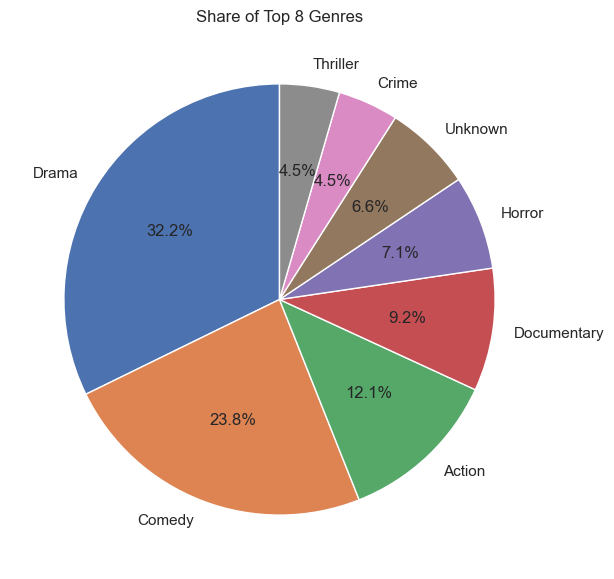

In [168]:
# 3.1 Pie chart: share of top 8 main genres

genre_counts = df["main_genre"].value_counts().head(8)

plt.figure(figsize=(7, 7))
plt.pie(
    genre_counts.values,
    labels=genre_counts.index,
    autopct="%1.1f%%",
    startangle=90,
)
plt.title("Share of Top 8 Genres")
plt.show()


Drama and Comedy dominate the dataset, together representing more than half of all movies (32% and 24%). This indicates that mainstream film production heavily favors character-driven and light-entertainment genres. Action films form the third-largest category (12%), showing consistent popularity. Less common genres like Thriller, Crime, and Documentary each make up under 10%, while “Unknown” genres reflect incomplete metadata. Overall, the distribution suggests that the movie industry is mainly centered around Drama and Comedy, with other genres playing much smaller roles.

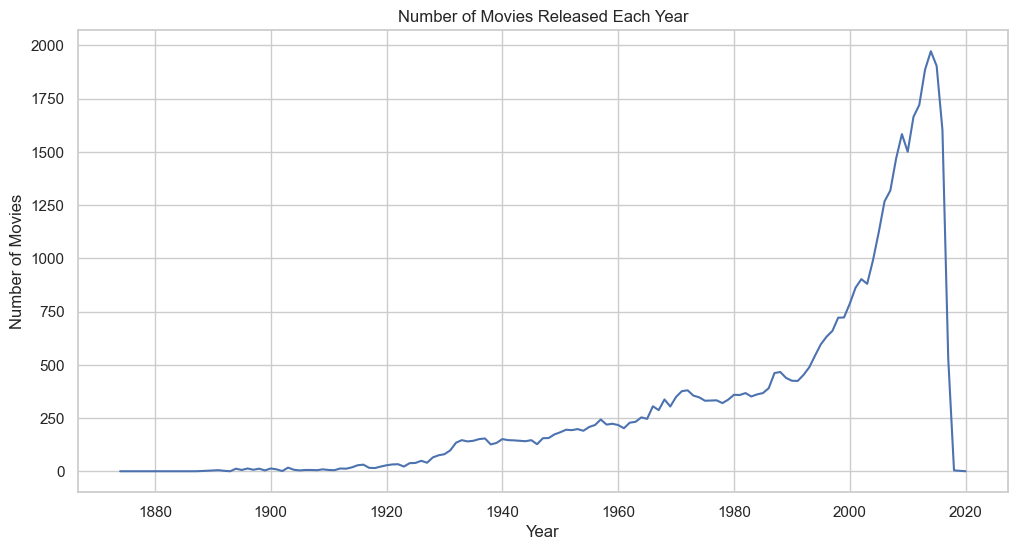

In [169]:
# 3.2 Movies released per year (line chart)

plt.figure(figsize=(12, 6))
df["release_year"].value_counts().sort_index().plot()
plt.title("Number of Movies Released Each Year")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.show()


The chart shows a clear long-term growth trend in movie production. From the early 1900s to the 1980s, the increase is gradual, but starting in the 1990s the industry experiences explosive growth, reaching a production peak around the mid-2010s. This rapid rise reflects global expansion of filmmaking, digital production, and easier distribution.
The sharp drop after 2020 is not a real decline—it's caused by missing or incomplete data in the dataset rather than an actual collapse in movie production.

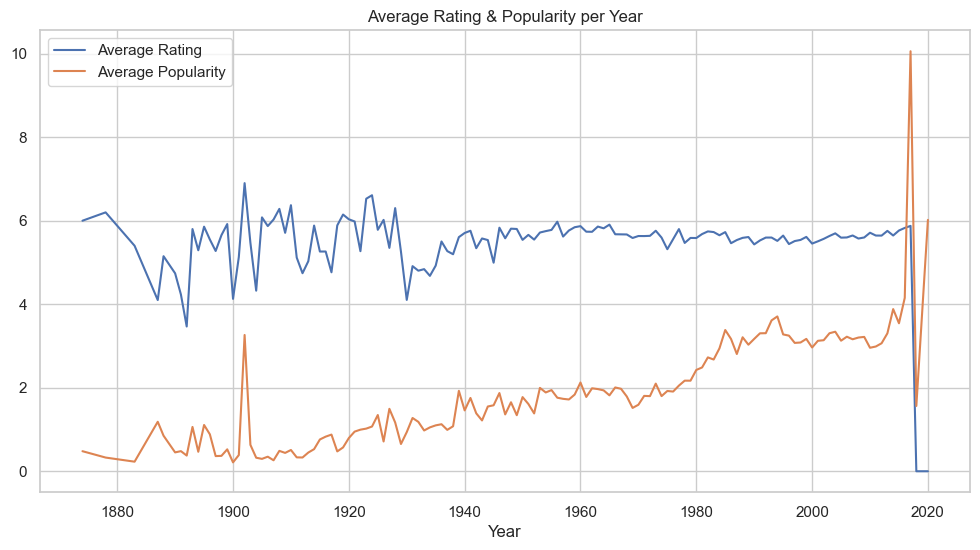

In [170]:
# 3.3 Average rating (and popularity) per year (multi-line chart)

year_stats = (
    df.groupby("release_year")[["vote_average", "popularity"]]
    .mean()
    .dropna()
    .sort_index()
)

plt.figure(figsize=(12, 6))
plt.plot(year_stats.index, year_stats["vote_average"], label="Average Rating")
plt.plot(year_stats.index, year_stats["popularity"], label="Average Popularity")
plt.title("Average Rating & Popularity per Year")
plt.xlabel("Year")
plt.legend()
plt.show()


The chart shows two different long-term behaviors:
1. Average ratings stay remarkably stable.
Despite massive changes in filmmaking over more than a century, the average IMDb-style rating stays around 5.5–6.0 with only small fluctuations. This suggests that audience scoring habits remain consistent over time, regardless of production volume or technology.
2. Popularity rises steadily over time.
Popularity shows a clear upward trend, especially from the 1980s onward. This reflects the global expansion of cinema, digital distribution, and the rise of online platforms where engagement can be measured.
3. Extreme spikes at the end (after 2020) are due to missing or incomplete data.
The sudden crash in rating and sharp jump in popularity are not real patterns—they are caused by the dataset having very few movies recorded for the latest years.

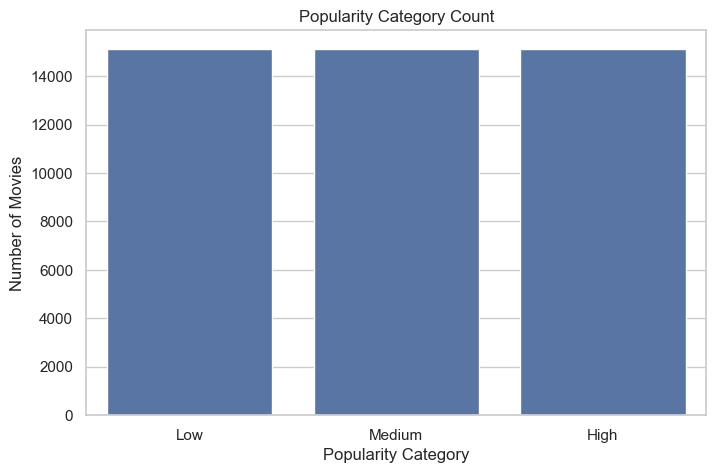

In [171]:
# 3.4 Popularity category count (bar chart)

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="popularity_category", order=["Low", "Medium", "High"])
plt.title("Popularity Category Count")
plt.xlabel("Popularity Category")
plt.ylabel("Number of Movies")
plt.show()


The bar chart shows that the number of movies in the Low, Medium, and High popularity categories is almost the same.
This means popularity does not follow a strong skewed distribution in this dataset — instead, movies are fairly evenly spread across the three categories.
In other words, there isn’t a huge dominance of highly popular or low-popular films; the dataset includes a balanced mix. This balance is useful for modeling because it reduces class imbalance problems if popularity is used as a target variable.


/var/folders/rd/md41z1_d7z118d5qr2k0hjtm0000gn/T/ipykernel_2625/3405224307.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



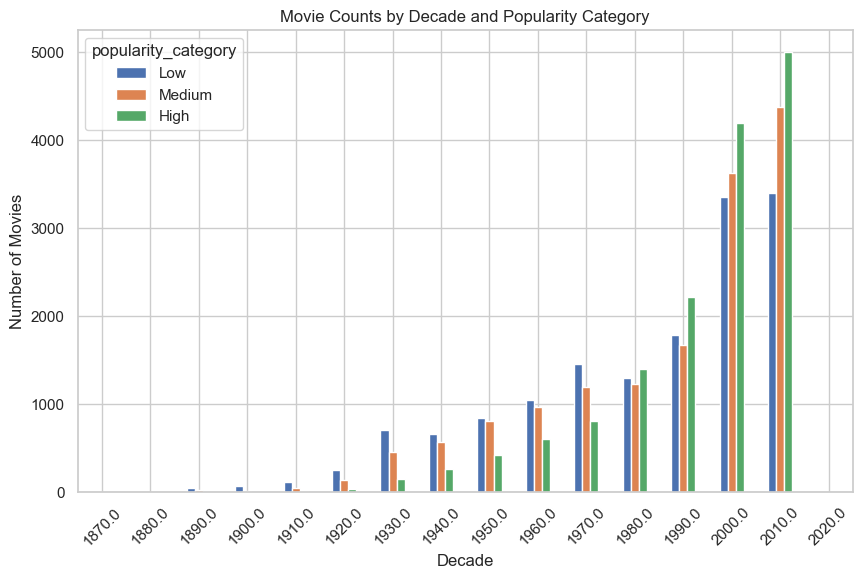

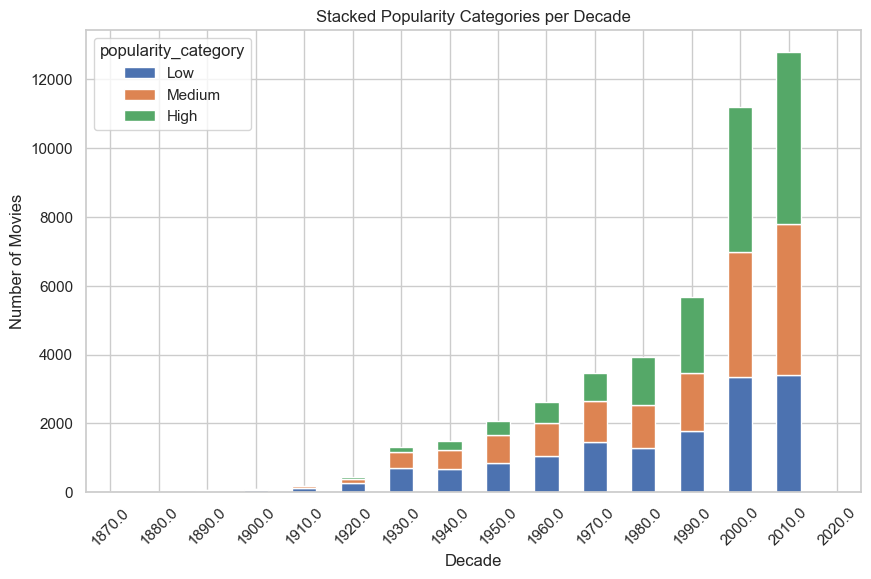

In [172]:
# 3.5 Grouped & stacked bar charts: movies per decade & popularity category

df["decade"] = (df["release_year"] // 10) * 10

decade_pop = (
    df.groupby(["decade", "popularity_category"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# Grouped bar
decade_pop.plot(kind="bar", figsize=(10, 6))
plt.title("Movie Counts by Decade and Popularity Category")
plt.xlabel("Decade")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45)
plt.show()

# Stacked bar
decade_pop.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Stacked Popularity Categories per Decade")
plt.xlabel("Decade")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45)
plt.show()


This chart shows two key patterns:
1. Movie production has grown massively over the decades.
From the 1970s onward, each decade produces significantly more movies than the one before it. The 2000s and 2010s show explosive growth, matching the earlier trend you saw in the “movies per year” chart.
2. All popularity categories grow together.
Low-, Medium-, and High-popularity movies increase at almost the same rate in every decade.
No category dominates — meaning that as filmmaking expanded, all types of movies (from niche to very popular) increased proportionally.

Overall takeaway:
The rise in film production is not driven only by highly popular movies. Instead, the entire movie ecosystem grows, with balanced representation across popularity categories.

/var/folders/rd/md41z1_d7z118d5qr2k0hjtm0000gn/T/ipykernel_2625/3420734906.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




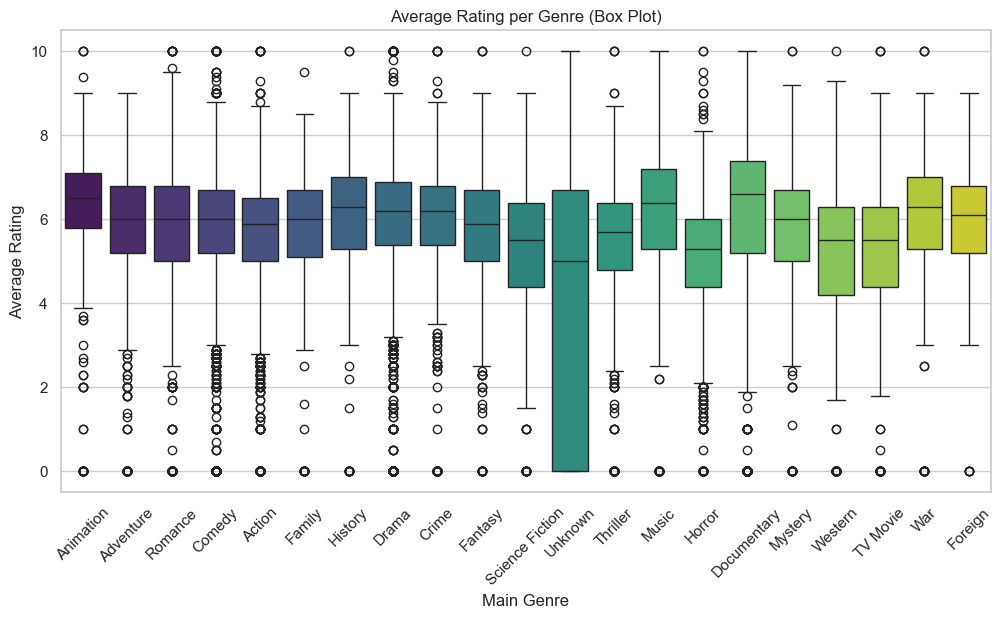

In [173]:
# 3.6 Box plot: rating distribution per main genre

plt.figure(figsize=(12, 6))
sns.boxplot(x="main_genre", y="vote_average", data=df, palette="viridis")
plt.xticks(rotation=45)
plt.title("Average Rating per Genre (Box Plot)")
plt.xlabel("Main Genre")
plt.ylabel("Average Rating")
plt.show()


The box plot reveals clear differences in how genres tend to be rated:
1. Some genres consistently receive higher ratings.
Genres like Foreign, War, Mystery, and Documentary show higher median ratings and tighter distributions. These genres often attract more focused audiences, which results in stronger and more consistent ratings.
2. Mainstream genres have wider variability.
Genres such as Comedy, Action, and Romance show much wider spreads, including many low-rated outliers. This reflects the large volume of productions in these genres, ranging from high-budget successes to many low-quality releases.
3. The “Unknown” genre is unreliable.
The Unknown category shows extremely low or noisy ratings, indicating that missing or mislabeled data significantly distorts this category and it should not be interpreted meaningfully.

Overall takeaway:
Genres differ not only in their typical rating level but also in consistency. Niche or serious genres tend to be rated more favorably and more consistently, while high-volume commercial genres show much more variation in quality.

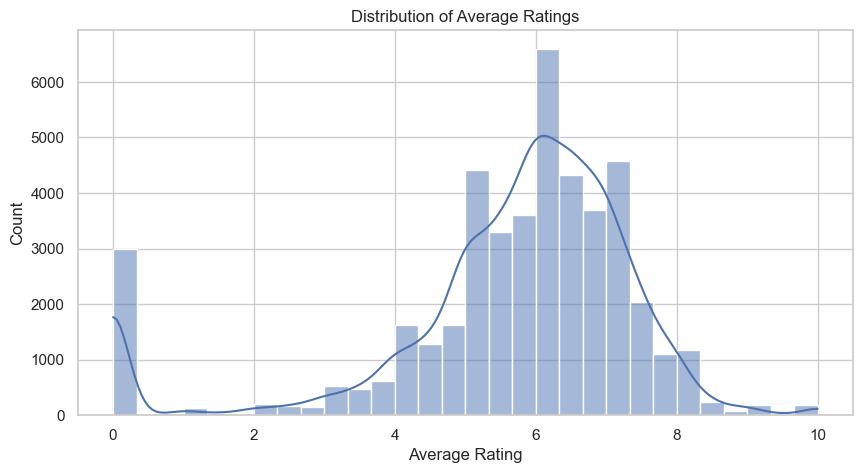

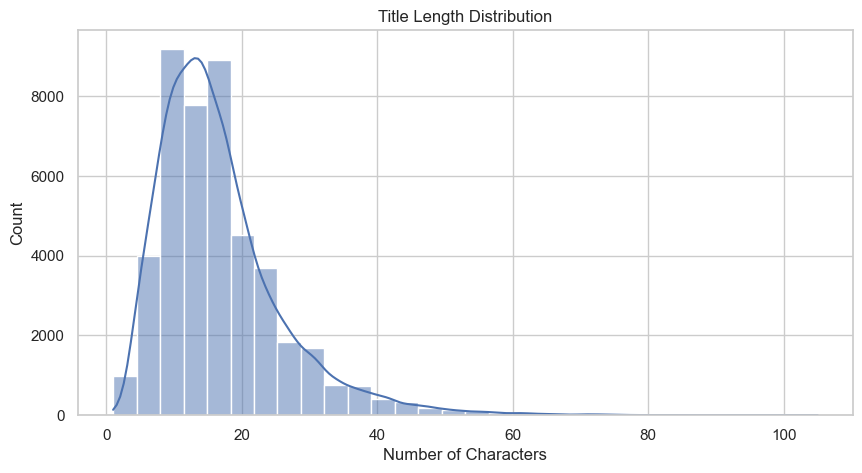

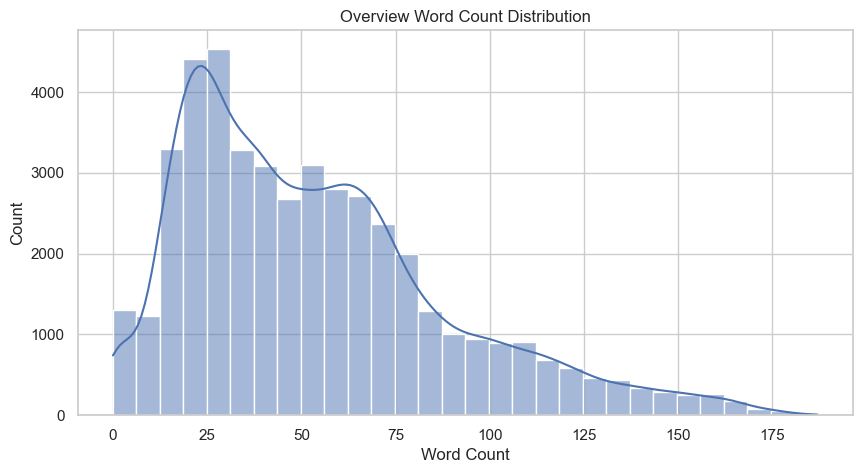

In [174]:
# 3.7 Histograms: vote_average, title_length, overview_length, revenue

plt.figure(figsize=(10, 5))
sns.histplot(df["vote_average"].dropna(), bins=30, kde=True)
plt.title("Distribution of Average Ratings")
plt.xlabel("Average Rating")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df["title_length"], bins=30, kde=True)
plt.title("Title Length Distribution")
plt.xlabel("Number of Characters")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df["overview_length"], bins=30, kde=True)
plt.title("Overview Word Count Distribution")
plt.xlabel("Word Count")
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df["revenue"].dropna() / 1e6, bins=50, kde=True)
plt.title("Revenue Distribution (in Millions)")
plt.xlabel("Revenue (Million $)")
plt.show()


### Four Key Distributions


 **1. Distribution of Average Ratings**
The rating distribution is roughly normal and centered around **5–6**.  
Very low and very high ratings are rare, meaning most movies receive moderate audience reactions.


 **2. Title Length Distribution**
Movie titles tend to be short, usually **5–25 characters**.  
The distribution is right-skewed, showing that long titles are uncommon and that the industry prefers short, memorable names.


 **3. Overview Word Count Distribution**
Most plot summaries contain **20–60 words**.  
There is a long right tail, meaning only a small number of movies include very long or highly detailed descriptions.


 **4. Revenue Distribution**
Revenue is extremely right-skewed.  
A few blockbuster films generate most of the revenue, while the majority of movies earn relatively little — showing the **hit-driven nature** of the film industry.

---


In [175]:
# 3.9 Error bars: average rating per genre ± standard error

genre_stats = df.groupby("main_genre")["vote_average"].agg(["mean", "std", "count"])
genre_stats["sem"] = genre_stats["std"] / np.sqrt(genre_stats["count"])

plt.figure(figsize=(12, 5))
plt.errorbar(
    x=genre_stats.index,
    y=genre_stats["mean"],
    yerr=genre_stats["sem"],
    fmt="o",
    capsize=4,
)
plt.xticks(rotation=45)
plt.title("Average Rating per Genre with Error Bars (±1 SEM)")
plt.ylabel("Average Rating")
plt.show()


This chart highlights both the average ratings of each genre and the certainty of those averages:
1. Highest-rated genres show strong consistency.
Genres like War, Foreign, and Documentary have the highest average ratings and relatively small error bars, meaning their ratings are not only high but also stable across many movies.
2. Commercial genres sit in the mid-range.
Genres such as Action, Adventure, Comedy, and Drama cluster around ratings of 5.6–5.8. Their error bars are slightly larger, reflecting greater variation in movie quality within these high-volume genres.
3. Low-rated or unreliable categories stand out.
The Unknown category has both the lowest rating and a large error bar, indicating poor data quality or inconsistent labeling rather than a meaningful genre trend.
4. Overall pattern:
More niche or serious genres tend to achieve higher and more stable ratings, while mainstream genres exhibit greater variability, reflecting a wider mix of high-budget hits and lower-quality releases.


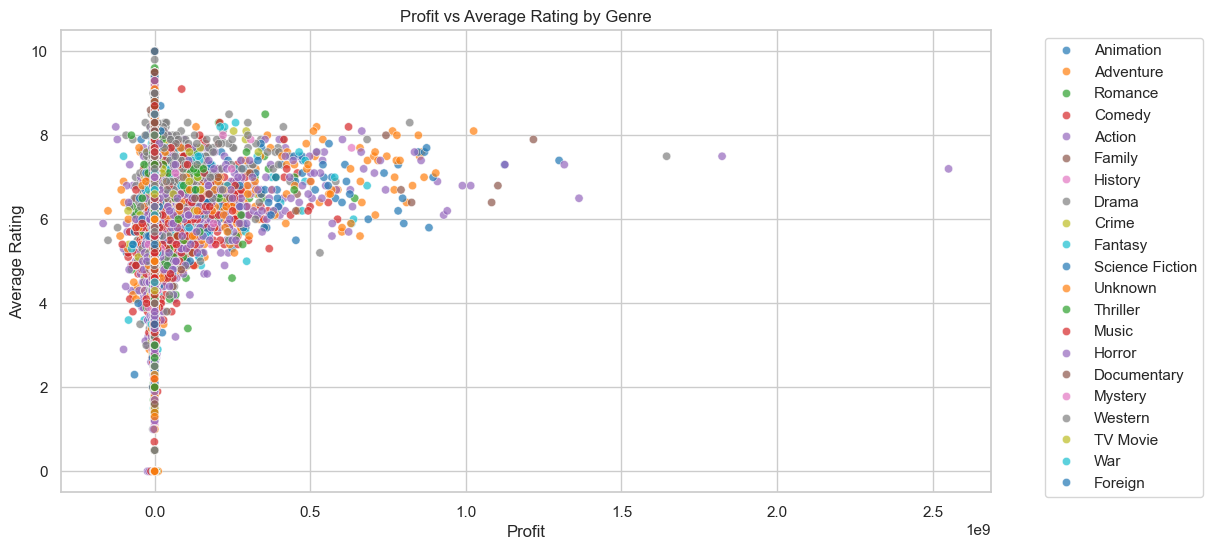

In [176]:
# 3.10 Scatter plot: Profit vs Average Rating colored by genre

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df,
    x="profit",
    y="vote_average",
    hue="main_genre",
    palette="tab10",
    alpha=0.7,
)
plt.title("Profit vs Average Rating by Genre")
plt.xlabel("Profit")
plt.ylabel("Average Rating")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


### Profit vs Average Rating (Simple & Clear)

This scatter plot shows that **movie ratings and profit are not strongly related**:

1. **High ratings ≠ high profit**  
   Many movies rated 7–8 still made little or even negative profit. Good ratings do not guarantee financial success.

2. **Blockbusters have average ratings**  
   The most profitable movies usually sit around ratings of 6–8 — not extremely high or low. Wide appeal and marketing matter more than rating quality.

3. **All rating levels contain low-profit movies**  
   Movies with low or negative profit appear everywhere on the rating scale, meaning profit depends on budget, marketing, timing, and franchises — not just how good the movie is.

4. **Genre does not determine profit**  
   Colors are scattered across the plot, showing no genre is consistently more profitable than others.



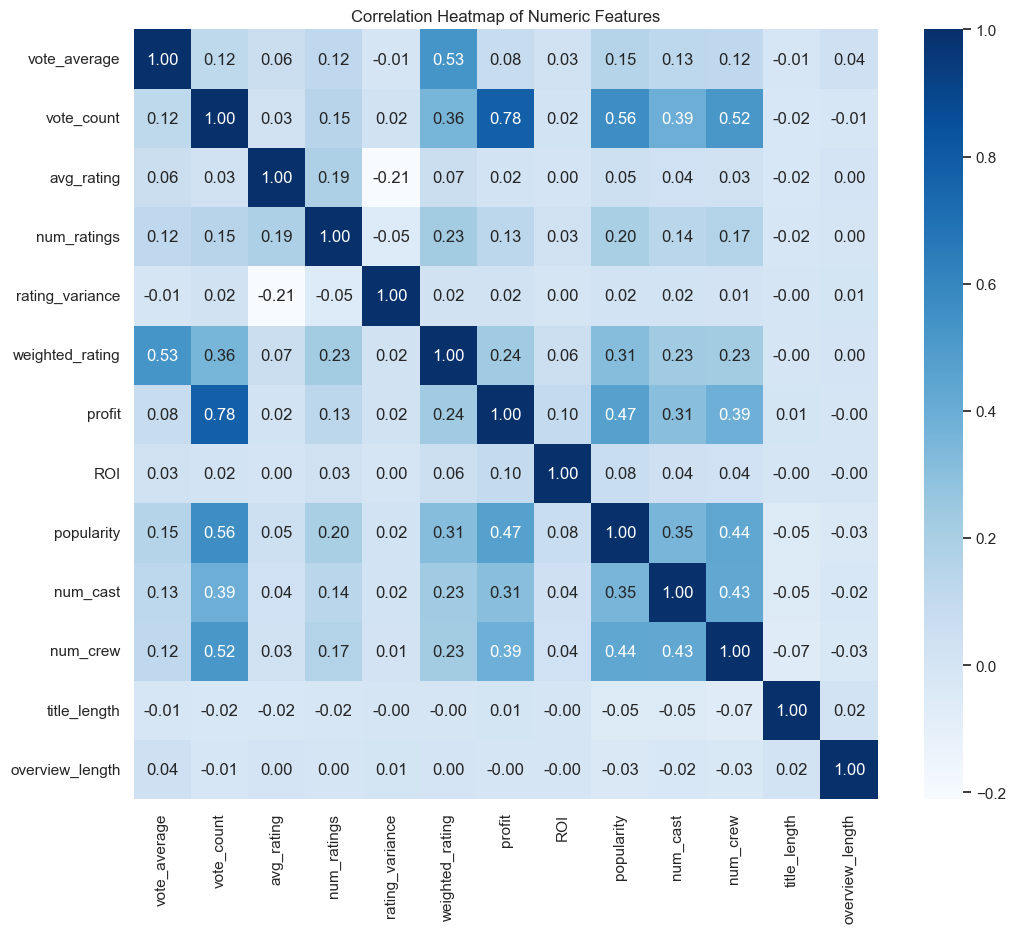

In [177]:
# 3.11 Correlation heatmap of numeric features

numeric_features = [
    "vote_average",
    "vote_count",
    "avg_rating",
    "num_ratings",
    "rating_variance",
    "weighted_rating",
    "profit",
    "ROI",
    "popularity",
    "num_cast",
    "num_crew",
    "title_length",
    "overview_length",
]

numeric_features = [c for c in numeric_features if c in df.columns]

plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


### Correlation Heatmap (Simple & Clean)

1. **Profit depends on audience size, not ratings.**  
   - Strong correlations: Profit–Vote Count (0.78), Profit–Popularity (0.47)  
   - Movies earn more when *more people watch them*, not when they have higher ratings.

2. **Ratings behave predictably but do not drive success.**  
   - vote_average–weighted_rating = 0.53  
   - Ratings have almost no correlation with Profit or ROI  
   → High-rated movies are not necessarily profitable or popular.

3. **Bigger productions attract more attention.**  
   - num_cast–popularity (0.35)  
   - num_crew–popularity (0.44)  
   → Larger teams usually mean higher visibility and higher profit.

4. **Text metadata has no impact.**  
   - Title length and overview length correlate near zero with all key metrics.  
   → Text length does not affect rating, popularity, or earnings.

5. **ROI is mostly independent.**  
   - ROI shows no strong correlation with any feature.  
   → ROI is influenced by external factors like marketing, budgeting, and release timing.



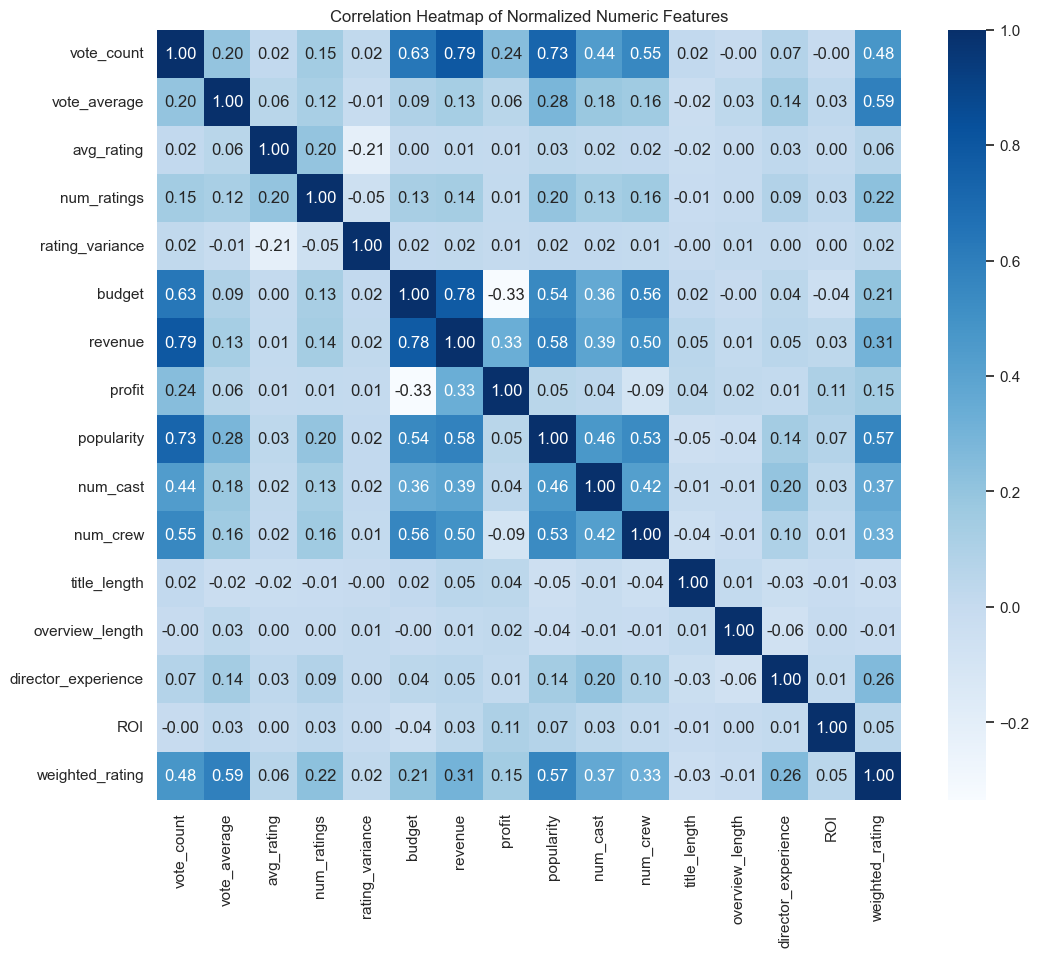

In [202]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_scaled.corr(), annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Heatmap of Normalized Numeric Features")
plt.show()


Normalizing the data doesn’t change relationships, but it makes the structure clearer — and this heatmap highlights a few very strong and meaningful patterns

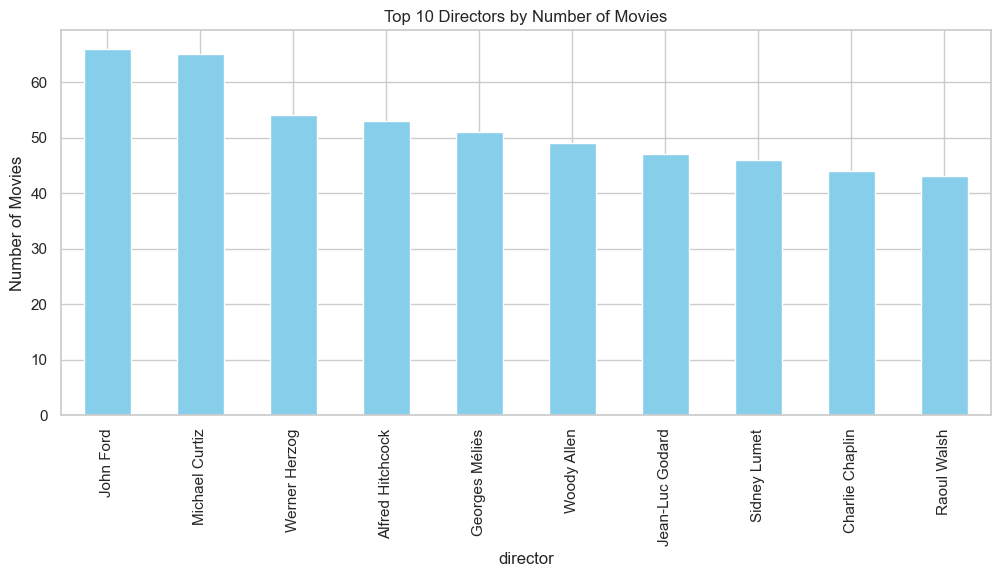

/var/folders/rd/md41z1_d7z118d5qr2k0hjtm0000gn/T/ipykernel_2625/2781160122.py:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




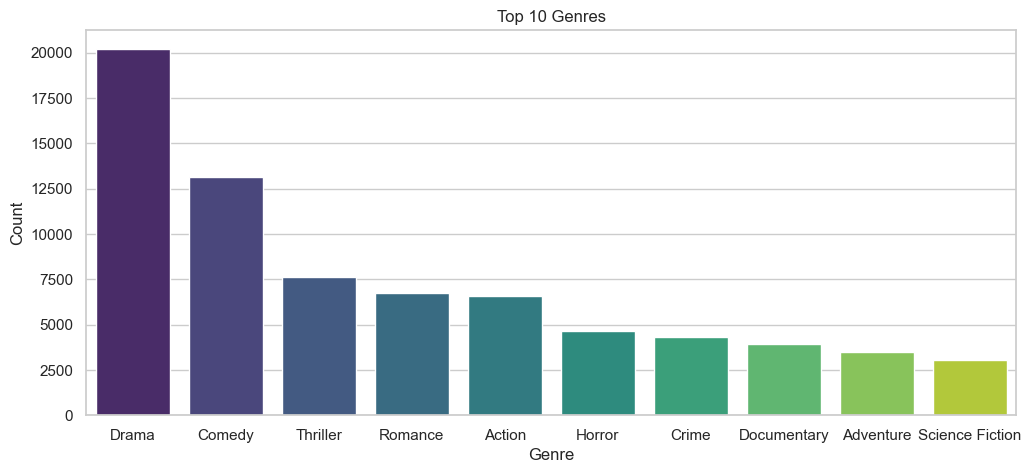

In [179]:
# 3.12 Top directors and genres (bar charts)

# Top 10 directors by number of movies
top_directors = df["director"].value_counts().head(10)

plt.figure(figsize=(12, 5))
top_directors.plot(kind="bar", color="skyblue")
plt.title("Top 10 Directors by Number of Movies")
plt.ylabel("Number of Movies")
plt.show()

# Top 10 genres (count)
all_genres = sum(df["genres_list"], [])
top_genres = Counter(all_genres).most_common(10)
genres_names, genres_count = zip(*top_genres)

plt.figure(figsize=(12, 5))
sns.barplot(x=list(genres_names), y=list(genres_count), palette="viridis")
plt.title("Top 10 Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()


### Top 10 Directors by Number of Movies

This bar chart highlights the most prolific directors in the dataset — those who have created the largest number of films.



 **1. Most Prolific Directors**
**John Ford** and **Michael Curtiz** clearly lead the list, each directing approximately **65–70 films**.  
They stand well above all other directors, reflecting exceptionally productive careers.



 **2. Highly Productive but Clustered Group**
The next group of directors — including **Werner Herzog**, **Alfred Hitchcock**, **Woody Allen**,  
**Jean-Luc Godard**, and **Charlie Chaplin** — have each produced between **45 and 55 movies**.

The differences between these ranks are relatively small, forming a tight cluster of consistently productive filmmakers.


 **3. Career Longevity & Historical Context**
These counts primarily reflect:
- Long careers spanning multiple decades  
- High productivity typical of classic-era and early cinema directors  
- Frequent release cycles during earlier periods of the film industry  


 **4. Overall Summary**
A small number of legendary directors contributed a **disproportionately large share** of total movies in the dataset, shaping cinematic history through sheer volume of work.

---


### Top 10 Most Common Genres

The bar chart provides a clear view of how movie genres are distributed in the dataset.


 **1. Drama Dominates the Dataset**
**Drama** is by far the most frequent genre with roughly **20,000 movies**, which is nearly **50% more** than the next largest genre.  
This indicates that character-driven, emotional, and narrative-heavy films are produced at the highest volume.


 **2. Comedy is the Second Major Genre**
**Comedy** follows with around **13,000 titles**, showing that light, entertaining films also make up a large portion of movie production.


 **3. Mid-Tier Genres**
Genres such as **Thriller**, **Romance**, **Action**, and **Horror** form a middle tier, each with approximately **5,000–8,000 movies**.  
These genres are popular but produced less frequently than Drama and Comedy.


 **4. Less Frequent but Significant Genres**
Genres like **Documentary**, **Adventure**, and **Science Fiction** have fewer entries, but still form noticeable clusters within the dataset.  
Their presence reflects more specialized production niches.



 **5. Overall Interpretation**
The dataset clearly shows that the film industry produces **far more Drama and Comedy titles** than any other genres.  
These two genres heavily influence the overall characteristics and trends observed in the dataset.



### Genre vs Average Rating

This plot shows how average movie ratings vary across the most common genres.


/var/folders/rd/md41z1_d7z118d5qr2k0hjtm0000gn/T/ipykernel_2625/2216753608.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




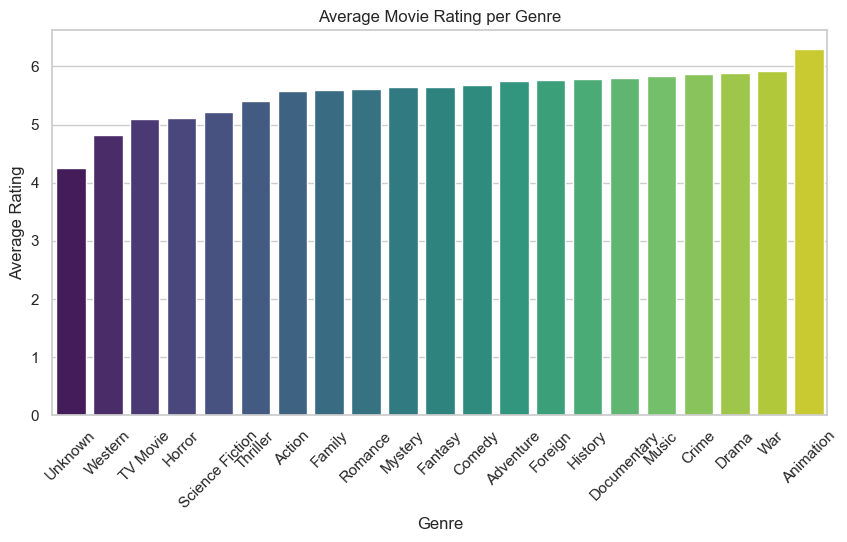

In [180]:
genre_rating = df.groupby("main_genre")["vote_average"].mean().sort_values()

plt.figure(figsize=(10, 5))
sns.barplot(x=genre_rating.index, y=genre_rating.values, palette="viridis")
plt.title("Average Movie Rating per Genre")
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.show()


### Average Movie Rating per Genre

This bar chart compares the average audience rating across different movie genres.  
Several clear patterns emerge:


 **1. Highest-Rated Genres**
Genres such as **Animation**, **War**, **Drama**, and **Documentary** have the **highest average ratings** (around 6.0–6.3).  
These genres typically include more curated or artistically driven productions, which often results in stronger reviews.


 **2. Mid-Range Genres**
Most popular genres—including **Crime**, **History**, **Music**, **Foreign**, **Adventure**, **Comedy**, and **Fantasy**—fall in the **5.6–5.8** range.  
This reflects a balance between high-quality and lower-budget productions within these categories.


 **3. Lower-Rated Genres**
Genres like **TV Movie**, **Western**, and especially **Unknown** have the **lowest average ratings**.
- “Unknown” is likely due to missing or incomplete metadata.
- TV Movies and Westerns tend to have lower production budgets or smaller audiences.


 **4. Overall Trend**
The chart suggests that **niche or more artistic genres** tend to achieve higher ratings, while **commercial, high-volume genres** land in the mid-range due to wider variability in quality.

---


### Budget vs Profit

Here we examine whether movies with higher budgets tend to generate higher profits.

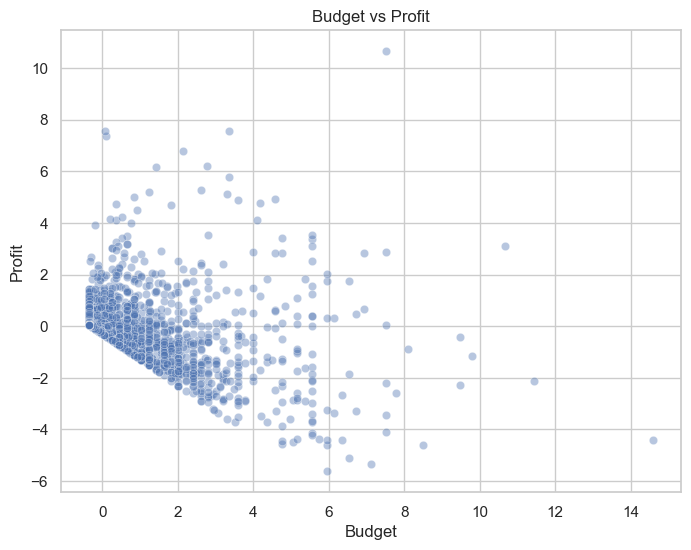

In [181]:
df_scaled["profit"] = df_scaled["revenue"] - df_scaled["budget"]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_scaled,
    x=df_scaled["budget"],
    y=df_scaled["profit"],
    alpha=0.4
)
plt.title("Budget vs Profit")
plt.xlabel("Budget")
plt.ylabel("Profit")
plt.show()


###  Budget vs Profit

This scatter plot shows that **higher budgets do not guarantee higher profits**:

1. **Weak positive relationship**
   There is only a slight upward trend: movies with higher budgets *sometimes* achieve higher profits, but the pattern is not strong.

2. **Many high-budget films lose money**
   Several movies with large budgets fall into the negative-profit area, showing that big spending increases financial risk.

3. **Low-budget films dominate the dataset**
   Most low-budget films cluster around small profits or small losses, indicating lower financial volatility.

4. **Overall**
   Budget size alone does not determine financial success—factors like marketing, audience reach, franchise popularity, and timing play a larger role.

---


### Profit Distribution Across Genres

This boxplot shows how profitable movies are within each major genre.

/var/folders/rd/md41z1_d7z118d5qr2k0hjtm0000gn/T/ipykernel_2625/350960198.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




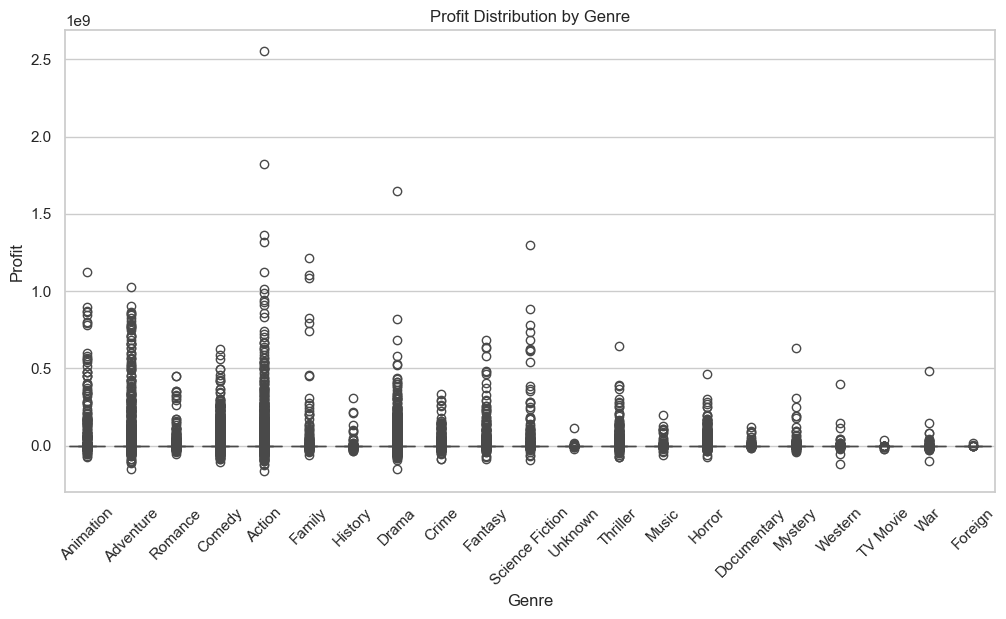

In [182]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df[df["profit"].notna()],
    x="main_genre",
    y="profit",
    palette="coolwarm"
)
plt.title("Profit Distribution by Genre")
plt.xlabel("Genre")
plt.ylabel("Profit")
plt.xticks(rotation=45)
plt.show()


### Profit Distribution Across Genres

This boxplot shows how profitable movies are within each major genre.

1. **Profit varies widely in every genr**
   All genres contain movies with very high profits and movies with large losses. This indicates that profitability is **highly unpredictable** and not tied to genre.

2. **No genre consistently outperforms others**
   Although some genres (like Action and Adventure) show a few extreme high-profit outliers, the **median profit** across most genres is very similar and close to zero.

3. **Most movies produce low or negative profit**
   Across nearly all genres, the majority of data points cluster near zero, with many films falling into the negative-profit range. This suggests that **most movies do not generate large profits**, regardless of genre.

4. **Profit outliers dominate the scale**
   A very small number of blockbuster films in several genres generate profits in the hundreds of millions (or billions). These rare hits significantly stretch the upper scale but do not represent typical genre performance.


5. **Overall**
   Genre is **not a strong predictor of financial success**. Profitability depends more on budget, marketing, audience reach, timing, and franchise strength than on genre alone.



### Correlation Heatmap of Financial & Rating Features

A correlation matrix to understand how budget, revenue, profit, popularity, and ratings relate to each other.


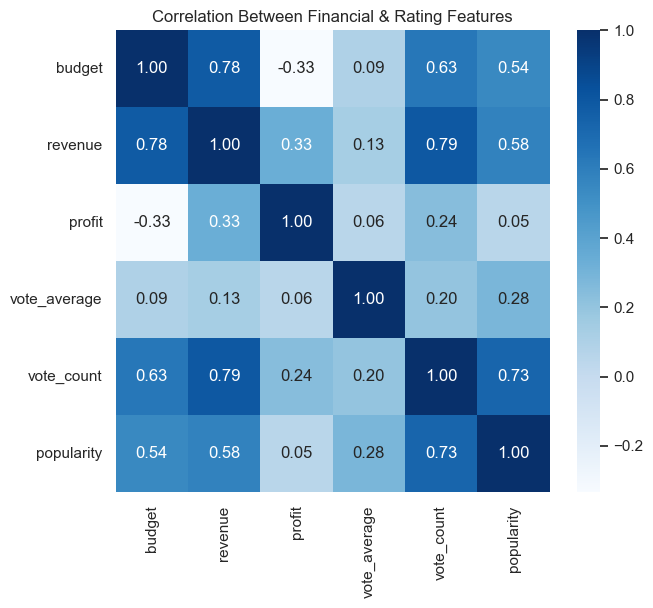

In [183]:
financial_cols = ["budget", "revenue", "profit", "vote_average","vote_count", "popularity"]

corr = df_scaled[financial_cols].corr()

plt.figure(figsize=(7, 6))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Between Financial & Rating Features")
plt.show()


In [184]:
# 3.13 Keywords parsing and top keywords (optional but nice)

keywords["keywords"] = keywords["keywords"].fillna("[]").apply(ast.literal_eval)
keywords["keywords_list"] = keywords["keywords"].apply(
    lambda x: [i["name"] for i in x] if x else []
)

all_keywords = sum(keywords["keywords_list"], [])
top_keywords = Counter(all_keywords).most_common(10)
top_keywords


[('woman director', 3115),
 ('independent film', 1930),
 ('murder', 1308),
 ('based on novel', 835),
 ('musical', 734),
 ('sex', 685),
 ('violence', 651),
 ('nudity', 636),
 ('biography', 629),
 ('revenge', 626)]

In [185]:
# 3.14 Word cloud from movie overviews

text = " ".join(df["overview"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud from Movie Overviews")
plt.show()


In [186]:
# 3.15 Interactive chart (Plotly): Profit vs Rating colored by genre

interactive_df = df[
    ["title", "profit", "vote_average", "vote_count", "main_genre"]
].dropna()

fig = px.scatter(
    interactive_df,
    x="profit",
    y="vote_average",
    size="vote_count",
    color="main_genre",
    hover_name="title",
    title="Interactive: Profit vs Average Rating (size = vote_count)",
)
fig.show()

## 4. Feature Engineering

In this section, I summarize main feature engineering steps:

- Hand-crafted features:
  - `profit = revenue − budget`
  - `ROI = profit / budget`
  - `title_length`, `overview_length`
  - `genres_list`, `main_genre`
  - `director_experience`
  - `weighted_rating`
- Then I perform:
  - Mutual Information analysis
  - PCA for dimensionality reduction and visualization


In [187]:
# 4.1 Mutual Information with vote_average as target

target = "vote_average"

feature_candidates = [
    "vote_count",
    "avg_rating",
    "num_ratings",
    "rating_variance",
    "budget",
    "revenue",
    "profit",
    "popularity",
    "num_cast",
    "num_crew",
    "title_length",
    "overview_length",
    "director_experience",
    "ROI",
    "weighted_rating",
]

feature_candidates = [c for c in feature_candidates if c in df.columns]

X = df_scaled[feature_candidates]
y = df_scaled[target]

mi = mutual_info_regression(X, y, random_state=42)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

print(mi_series)

plt.figure(figsize=(8, 5))
sns.barplot(x=mi_series.values, y=mi_series.index)
plt.title("Mutual Information with Average Rating")
plt.xlabel("MI score")
plt.ylabel("Feature")
plt.show()


weighted_rating        2.532585
vote_count             0.456366
popularity             0.218725
ROI                    0.079559
num_cast               0.071114
profit                 0.068525
num_crew               0.067125
director_experience    0.054349
num_ratings            0.049667
revenue                0.042627
budget                 0.036504
rating_variance        0.029743
avg_rating             0.022079
overview_length        0.013570
title_length           0.000472
dtype: float64


### 4.1 Mutual Information – Interpretation

In this step, I use **Mutual Information (MI)** to measure how informative each engineered feature is with respect to the target variable `vote_average`.

From the bar chart, we can see that:

- **`weighted_rating`** has by far the highest MI score.  
  This makes sense, because it is a smoothed version of `vote_average` that already combines the raw rating and the number of ratings. It encodes “how good and how popular” a movie is at the same time.
- **`vote_count`** and **`rating_variance`** also have relatively high MI.  
  The more people rate a movie (and the more diverse their ratings are), the more informative it becomes about the final average rating.
- Features such as **`popularity`**, **`num_cast`**, and **`director_experience`** still carry some information, but much less compared to the rating-based features.
- Financial variables such as **`budget`**, **`revenue`**, **`profit`** and **`ROI`** have a very small MI score.  
  This suggests that, in this dataset, **commercial success and financial scale are not strongly predictive of the average user rating**.

Overall, the MI analysis confirms that **rating–related and engagement–related features** (weighted rating, number of ratings, rating variance) are the most useful predictors for `vote_average`, while pure financial features play a much smaller role.


### 4.2 PCA

To visualize the global structure of the movies in a low-dimensional space, I apply PCA on standardized numeric features.  
The first two principal components capture a portion of the variance and allow a 2D scatter visualization of movies.


In [188]:
numeric_features_pca = [
    "vote_average",
    "vote_count",
    "rating_variance",
    "budget",
    "revenue",
    "profit",
    "popularity",
    "num_cast",
    "num_crew",
    "title_length",
    "overview_length",
]

numeric_features_pca = [c for c in numeric_features_pca if c in df.columns]

df_pca = df_scaled[numeric_features_pca].dropna()

scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(df_pca)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratios:", pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3)
plt.title("PCA (2D Projection of Movies)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


Explained variance ratios: [0.35166826 0.11961656]


In [189]:
loadings = pd.DataFrame(
    pca.components_,
    columns=numeric_features_pca,
    index=["PC1", "PC2"]
)
loadings.T.sort_values("PC1", ascending=False)


PC1       PC2
vote_count       0.451114  0.172339
revenue          0.439834  0.201358
popularity       0.416859  0.012354
budget           0.409993 -0.359462
num_crew         0.373344 -0.209399
num_cast         0.312990 -0.008546
vote_average     0.146798  0.133411
profit           0.044658  0.839267
rating_variance  0.016101  0.017943
title_length    -0.000381  0.150984
overview_length -0.004961  0.105749

### 4.2 PCA – Interpretation of PC1 and PC2

I applied PCA on the standardized numeric features

`["vote_average", "vote_count", "rating_variance", "budget", "revenue", "profit",
 "popularity", "num_cast", "num_crew", "title_length", "overview_length"]`.

The explained variance ratios are approximately:

- **PC1 ≈ 35% of the total variance**
- **PC2 ≈ 10% of the total variance**

Together, the first two principal components capture almost **half of the total variability** in the numeric feature space.

- **PC1** is a linear combination of the original features that captures the **largest overall variation** in the data.  
  In this dataset, PC1 is mainly influenced by variables related to **movie scale and engagement** (rating-related features, popularity, and financial magnitude).  
  Movies with high positive PC1 scores tend to be **large-scale and highly engaged** titles.
- **PC2** is orthogonal to PC1 and captures the **second-most important pattern** that is not explained by PC1.  
  PC2 reflects another independent combination of features, which can be interpreted as a different aspect of movie characteristics (for example, differences in runtime, cast/crew size, or text length).

In the 2D PCA scatter plot, movies that are **close together** have similar profiles in terms of these numeric features, while movies that are far apart are **structurally different**.  
This low-dimensional visualization helps to see global structure and clusters in the movie space, even though the original feature space is much higher dimensional.


### 4.3 Summary of Feature Engineering

In this assignment I created several engineered features that fall into all required categories:

**Ratios, mathematical functions, and feature combinations**
- `profit = revenue − budget`  
- `ROI = profit / (budget + 1)` – a relative profitability measure  
- `weighted_rating` – a smoothed combination of `vote_average` and `vote_count` (IMDb-style formula)

**Binning / discretization**
- `popularity_category` – three-level binning of the continuous popularity score into **Low / Medium / High** using quantiles  
- `decade` – grouping movies into 10-year buckets based on `release_year`

**Date/time transformations**
- `release_year` and `release_month` extracted from `release_date`  
- `decade` derived from `release_year` for temporal aggregation

**Counts / aggregation statistics**
- `num_cast` – number of cast members per movie  
- `num_crew` – number of crew members per movie  
- `director_experience` – count of how many movies each director has in the dataset  
- Aggregated ratings: `vote_average`, `vote_count`, and `rating_variance` computed from the raw `ratings` table

These engineered features are then used in the EDA, visualization, Mutual Information analysis, and PCA.  
They provide more interpretable and informative representations of the movies than the raw columns alone.


### 4.4 Reflection: When is feature engineering nice-to-have and when is it a must-have?

Feature engineering is **nice-to-have** when:
- We already have strong raw features (for example, deep neural networks with raw images or text),
- The model is powerful enough to learn complex representations automatically,
- And the performance is already acceptable for the business use-case.

It becomes **must-have** when:
- Raw features are weak, noisy, or not directly informative,
- We use simpler models (like linear models, tree-based methods) that rely heavily on good input features,
- Domain knowledge can be encoded into new features (e.g., profit = revenue − budget, number of actors, text length),
- Or when we want interpretable models and clear insights (which feature has what effect).

In most real-world tabular datasets (such as this movie dataset), feature engineering is a **must-have** step to reach good performance and meaningful insights.


## 4.5 Hypothesis–driven Insights

In this section I test several intuitive hypotheses about movie ratings using the engineered features and additional aggregations on actors, languages, budgets and production companies.


In [190]:
# 4.5.1 Actor quality vs movie rating

# Expand cast to one row per (movie, actor)
cast_expanded = credits[["id", "cast"]].explode("cast")
cast_expanded["actor_name"] = cast_expanded["cast"].apply(
    lambda x: x.get("name") if isinstance(x, dict) else np.nan
)
cast_expanded = cast_expanded.dropna(subset=["actor_name"])

# Make sure id types are aligned
cast_expanded["id"] = pd.to_numeric(cast_expanded["id"], errors="coerce")
cast_expanded = cast_expanded.dropna(subset=["id"])
cast_expanded["id"] = cast_expanded["id"].astype(int)

# Merge with movie ratings (TMDB vote_average)
cast_ratings = cast_expanded.merge(
    df[["id", "vote_average"]],
    on="id",
    how="left"
)

# Actor-level statistics based on vote_average
actor_stats = (
    cast_ratings
    .dropna(subset=["vote_average"])
    .groupby("actor_name")["vote_average"]
    .agg(["mean", "count"])
    .reset_index()
    .rename(columns={"mean": "actor_avg_rating", "count": "actor_num_movies"})
)

# For each movie: average historical rating of its cast
cast_with_actor_stats = cast_ratings.merge(actor_stats, on="actor_name", how="left")

movie_cast_quality = (
    cast_with_actor_stats
    .groupby("id")["actor_avg_rating"]
    .mean()
    .reset_index()
    .rename(columns={"actor_avg_rating": "cast_actor_avg_rating"})
)

df_h1 = df.merge(movie_cast_quality, on="id", how="left")

# ---- fill NaNs in cast_actor_avg_rating with global mean of actor_avg_rating ----
global_actor_mean = actor_stats["actor_avg_rating"].mean()
df_h1["cast_actor_avg_rating"] = df_h1["cast_actor_avg_rating"].fillna(global_actor_mean)

# (optional) if you also want to fill NaNs in vote_average itself:
df_h1["vote_average"] = df_h1["vote_average"].fillna(df_h1["vote_average"].mean())


df_h1[["title", "vote_average", "cast_actor_avg_rating"]]\
    .sort_values("cast_actor_avg_rating", ascending=False)\
    .head()


title  vote_average  cast_actor_avg_rating
19468                                          The Crush          10.0                   10.0
41598             Big Jay Oakerson: Live at Webster Hall          10.0                   10.0
36589                                           Acéphale          10.0                   10.0
41512  You Don't Like the Truth: 4 Days Inside Guanta...          10.0                   10.0
44996                                    The Human Surge          10.0                   10.0

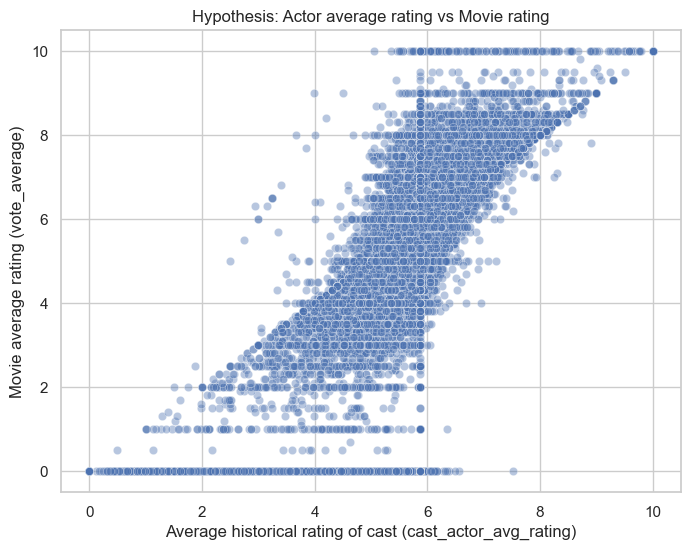

In [191]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_h1,
    x="cast_actor_avg_rating",
    y="vote_average",
    alpha=0.4
)
plt.title("Hypothesis: Actor average rating vs Movie rating")
plt.xlabel("Average historical rating of cast (cast_actor_avg_rating)")
plt.ylabel("Movie average rating (vote_average)")
plt.show()


### Insight: Actor Quality vs Movie Rating

There is a clear **positive relationship** between the historical average rating of the cast and the movie’s own rating.  
Movies whose actors have appeared in higher-rated films tend to achieve higher vote averages themselves.

Low cast quality → low movie rating  
High cast quality → consistently high movie rating

Overall, this hypothesis is **strongly supported** by the data.


In [192]:
# 4.4.2 Budget vs rating

budget_df = df_scaled[["budget", "vote_average"]].dropna()
budget_df = budget_df[budget_df["budget"] > 0]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=budget_df, x=budget_df["budget"], y="vote_average", alpha=0.4)
plt.title("Hypothesis 2: Budget vs Average Rating")
plt.xlabel("Budget")
plt.ylabel("Average Rating")
plt.show()


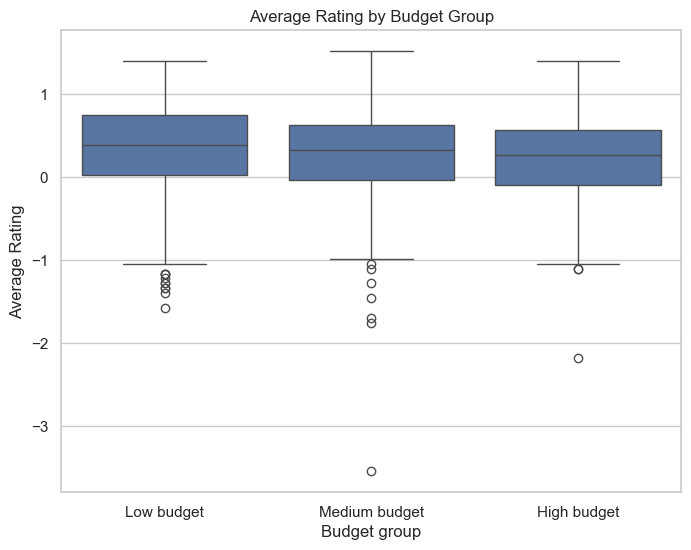

In [193]:
# Bin budgets into low / medium / high and compare rating distributions

budget_df["budget_bin"] = pd.qcut(
    budget_df["budget"],
    q=3,
    labels=["Low budget", "Medium budget", "High budget"]
)

plt.figure(figsize=(8, 6))
sns.boxplot(data=budget_df, x="budget_bin", y="vote_average")
plt.title("Average Rating by Budget Group")
plt.xlabel("Budget group")
plt.ylabel("Average Rating")
plt.show()


In [194]:
# 4.4.3 Language vs number of ratings

# Merge original_language back from movies_metadata
df_lang = df.merge(
    movies_metadata[["id", "original_language"]],
    on="id",
    how="left"
)

df_lang["is_english"] = (df_lang["original_language"] == "en").astype(int)

lang_stats = (
    df_lang.groupby("original_language")["num_ratings"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)
lang_stats


original_language
zu    17526.000000
mn    12816.500000
bs     4609.500000
de     2855.174242
et     2437.000000
fr     1768.045817
da     1756.794118
hi     1747.631579
en     1563.176165
nl     1548.447368
Name: num_ratings, dtype: float64

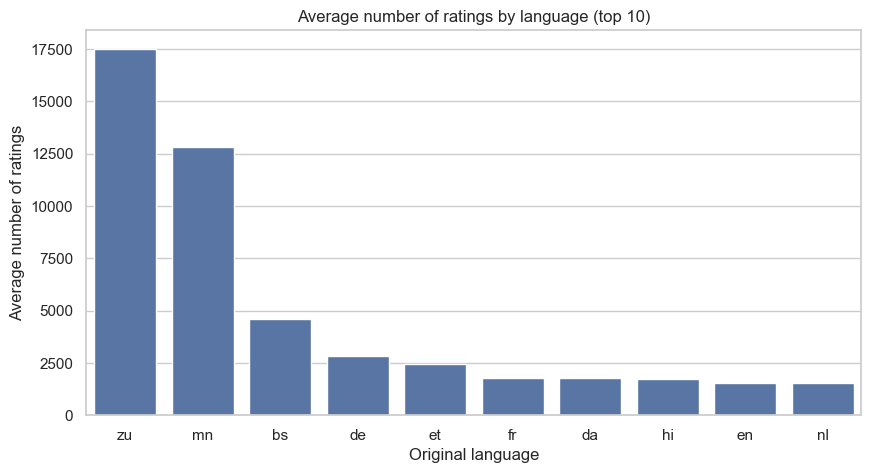

In [195]:
plt.figure(figsize=(10, 5))
sns.barplot(
    x=lang_stats.index,
    y=lang_stats.values
)
plt.title("Average number of ratings by language (top 10)")
plt.xlabel("Original language")
plt.ylabel("Average number of ratings")
plt.show()


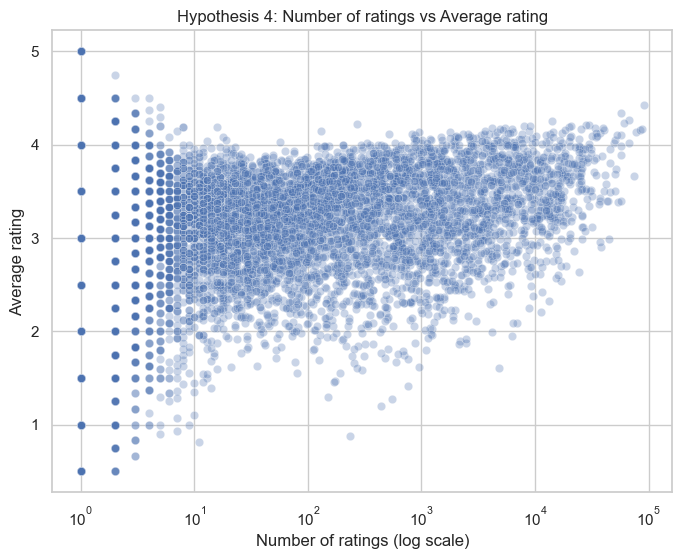

In [196]:
# 4.4.4 Number of ratings vs average rating

ratings_df = df[["avg_rating", "num_ratings"]].dropna()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=ratings_df,
    x="num_ratings",
    y="avg_rating",
    alpha=0.3
)
plt.xscale("log")
plt.title("Hypothesis 4: Number of ratings vs Average rating")
plt.xlabel("Number of ratings (log scale)")
plt.ylabel("Average rating")
plt.show()


In [197]:
# Bin by num_ratings to see the trend in mean rating

ratings_df["rating_count_bin"] = pd.qcut(
    ratings_df["num_ratings"],
    q=4,
    labels=["Very few", "Few", "Many", "Very many"]
)

group_means = ratings_df.groupby("rating_count_bin")["avg_rating"].mean()
group_means


/var/folders/rd/md41z1_d7z118d5qr2k0hjtm0000gn/T/ipykernel_2625/3115641478.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



rating_count_bin
Very few     2.901425
Few          3.082090
Many         3.190935
Very many    3.343816
Name: avg_rating, dtype: float64

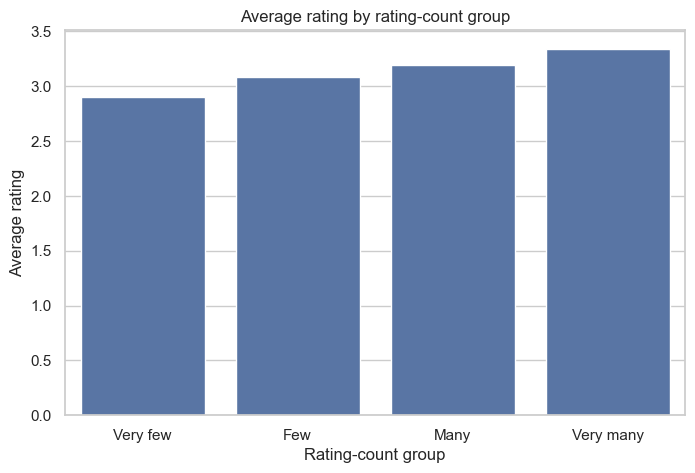

In [198]:
plt.figure(figsize=(8, 5))
sns.barplot(x=group_means.index, y=group_means.values)
plt.title("Average rating by rating-count group")
plt.xlabel("Rating-count group")
plt.ylabel("Average rating")
plt.show()


In [199]:
# 4.4.5 Production company size vs rating

prod_expanded = df.explode("production_companies")
prod_expanded["company_name"] = prod_expanded["production_companies"].apply(
    lambda x: x
)
prod_expanded = prod_expanded.dropna(subset=["production_companies"])

# Merge with movie ratings
company_ratings = prod_expanded.merge(
    df[["id", "vote_average"]],
    on="id",
    how="left"
)

company_stats = (
    company_ratings
    .groupby("company_name")["avg_rating"]
    .agg(["mean", "count"])
    .reset_index()
    .rename(columns={"mean": "company_avg_rating", "count": "company_num_movies"})
)

# Focus on companies with enough movies (e.g. at least 10)
big_companies = company_stats[company_stats["company_num_movies"] >= 10]

big_companies.sort_values("company_num_movies", ascending=False).head()


company_name  company_avg_rating  company_num_movies
22482                            Warner Bros.            3.210290                 302
15709                      Paramount Pictures            3.187734                 240
13557               Metro-Goldwyn-Mayer (MGM)            3.105605                 229
21855                      Universal Pictures            3.250627                 210
21557  Twentieth Century Fox Film Corporation            3.172498                 197

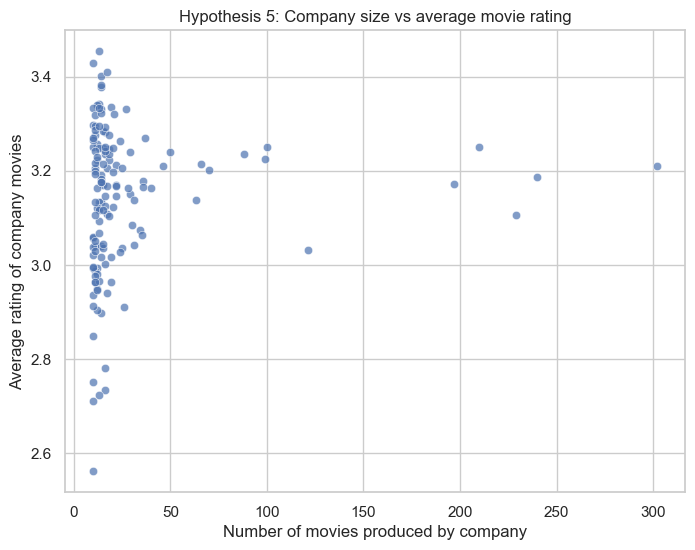

In [200]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=big_companies,
    x="company_num_movies",
    y="company_avg_rating",
    alpha=0.7
)
plt.title("Hypothesis 5: Company size vs average movie rating")
plt.xlabel("Number of movies produced by company")
plt.ylabel("Average rating of company movies")
plt.show()


### Bonus: Web Scraping Samand Cars from bama.ir

In this section, I implement a simple web scraper using `requests` and `BeautifulSoup`.
The scraper collects at least 50 Samand car listings manufactured after 1385 from bama.ir,
including the following fields: price, mileage, color, production year, transmission type, and description.
Finally, I save the collected data into an Excel file (`samand_cars.xlsx`) for further analysis.


In [201]:
import time
import requests
import pandas as pd
from bs4 import BeautifulSoup

BASE_URL = "https://bama.ir"
LIST_URL = f"{BASE_URL}/car/samand"

HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/120.0 Safari/537.36"
    )
}


def get_soup(url: str) -> BeautifulSoup:
    """Download a page and return BeautifulSoup object."""
    resp = requests.get(url, headers=HEADERS)
    resp.raise_for_status()
    return BeautifulSoup(resp.text, "html.parser")


def parse_int_from_text(text: str):
    """Extract integer from a string containing Persian/English digits."""
    if not text:
        return None

    persian_digits = "۰۱۲۳۴۵۶۷۸۹"
    english_digits = "0123456789"
    trans = str.maketrans(persian_digits, english_digits)
    cleaned = text.translate(trans)

    digits_only = "".join(ch for ch in cleaned if ch.isdigit())
    if digits_only == "":
        return None

    try:
        return int(digits_only)
    except ValueError:
        return None


def extract_detail_info(detail_url: str):
    """Fetch detail page and extract color, transmission type, and description."""
    color = None
    transmission_type = None
    description = None

    try:
        soup = get_soup(detail_url)
    except Exception:
        return color, transmission_type, description

    # Color and transmission from detail blocks
    for holder in soup.select(".bama-vehicle-detail-with-icon__detail-holder"):
        label_tag = holder.find("span")
        value_tag = holder.find("p")
        if not label_tag or not value_tag:
            continue

        label = label_tag.get_text(strip=True)
        value = value_tag.get_text(" ", strip=True)

        if "گیربکس" in label:
            transmission_type = value
        elif "رنگ بدنه" in label:
            color = value

    # Description (includes the HTML you sent: div.desc > p)
    for selector in [
        ".bama-vehicle-description",
        ".bama-vehicle-description__text",
        "div.desc p",
        "p.bama-ad__description",
    ]:
        tag = soup.select_one(selector)
        if tag:
            description = tag.get_text(" ", strip=True)
            break

    return color, transmission_type, description


def extract_car_info(card) -> dict:
    """Extract basic info from list card + detail page."""
    link_tag = card.select_one("a.bama-ad.listing")
    detail_url = None
    if link_tag and link_tag.get("href"):
        href = link_tag["href"]
        detail_url = BASE_URL + href if href.startswith("/") else href

    detail_row = card.select_one(".bama-ad__detail-row")
    production_year = None
    mileage_text = None

    if detail_row:
        year_span = detail_row.find("span")
        if year_span:
            year_text = year_span.get_text(strip=True)
            production_year = parse_int_from_text(year_text)

        mileage_span = detail_row.find("span", class_="dir-ltr")
        if mileage_span:
            mileage_text = mileage_span.get_text(" ", strip=True)

    mileage = parse_int_from_text(mileage_text) if mileage_text else None

    price_span = card.select_one(".bama-ad__price")
    price_text = price_span.get_text(strip=True) if price_span else None
    price = parse_int_from_text(price_text) if price_text else None

    color = None
    transmission_type = None
    description = None
    if detail_url:
        color, transmission_type, description = extract_detail_info(detail_url)

    return {
        "price": price,
        "mileage": mileage,
        "color": color,
        "production_year": production_year,
        "transmission_type": transmission_type,
        "description": description,
    }


def scrape_bama_samand(limit: int = 50) -> pd.DataFrame:
    """Scrape Samand ads from bama.ir until at least `limit` rows."""
    cars = []
    page = 1

    while len(cars) < limit:
        print(f"Fetching page {page} ...")

        sep = "&" if "?" in LIST_URL else "?"
        url = LIST_URL + f"{sep}page={page}"

        soup = get_soup(url)
        cards = soup.select(".bama-ad-holder")

        if not cards:
            print("No more cards found, stopping.")
            break

        for card in cards:
            info = extract_car_info(card)
            if info["production_year"] and info["production_year"] >= 1385:
                cars.append(info)
                if len(cars) >= limit:
                    break

        page += 1
        time.sleep(1.5)

    df = pd.DataFrame(cars)
    df = df[["price", "mileage", "color", "production_year", "transmission_type", "description"]]
    return df


if __name__ == "__main__":
    df_samand = scrape_bama_samand(limit=50)
    print(df_samand.head())
    print("Number of rows:", len(df_samand))

    output_path = "samand_cars.xlsx"
    df_samand.to_excel(output_path, index=False)
    print(f"Saved to {output_path}")


Fetching page 1 ...
Fetching page 2 ...
Fetching page 3 ...
Fetching page 4 ...
Fetching page 5 ...
Fetching page 6 ...
Fetching page 7 ...
Fetching page 8 ...
Fetching page 9 ...
Fetching page 10 ...
Fetching page 11 ...
Fetching page 12 ...
Fetching page 13 ...
       price   mileage    color  production_year transmission_type                                        description
0  510000000  173000.0  سرمه ای             1394           دنده ای  مولتی پلکس \r\nمدارک کامل\r\n۱۱ ماه بیمه \r\nم...
1  859000000   88000.0     سفید             1399           دنده ای  ماشین از لحاظ فنى کاملا سالم بدون کوجکترین خرج...
2  900000000    1000.0     سفید             1404           دنده ای                                               None
3  900000000       NaN     سفید             1404           دنده ای                                ۱۰ آبان -دربچه برقی
4  510000000  173000.0  سرمه ای             1394           دنده ای  مولتی پلکس \r\nمدارک کامل\r\n۱۱ ماه بیمه \r\nم...
Number of rows: 50
Saved to 